# Introduction to Sionna RT

In this notebook, you will:

- Understand all the steps and frameworks of AMDNLOC.
- Follow and execute each line of code to generate data, process data, train neural networks, modify models during training, compare results, and more.
- After understanding this program, you can identify areas for improvement and enhancement. I warmly welcome anyone who needs to use my code, read my articles, and cite my work in their own research.
- If you have ideas for further improvements or new directions for enhancement, feel free to contact me. We can discuss and collaborate to create more meaningful and valuable contributions. I am very eager to continuously improve and refine my work and code!


## Table of Contents
* [Background Information](#background-information)
* [Dataset Generation](#dataset-generation)
* [AMDNLOC Multi-sources Framework](#amdnloc-multi-sources-framework)
* [Training and Testing Datasets Generation](#training-and-testing-datasets-generation)
* [Deep Learning Network Training](#deep-learning-network-training)
* [Some Visulization](#some-visulization)


## Background Information

The development of MIMO-OFDM enables the unique characterization of each point in a scene through multi-path effects. Fingerprint-based localization methods utilize channel information that reflects multi-path features, such as received signal strength (RSS), channel impulse response (CIR), channel frequency response (CFR), and angle-delay channel amplitude matrix (ADCAM), as fingerprints to infer coordinates. However, current fingerprint localization algorithms typically select a single type of channel information as the fingerprint, failing to fully capture the distinctiveness of each location. This leads to situations where distant points within a scene exhibit nearly identical fingerprints, thereby violating the assumption of independent and identically distributed (i.i.d.) data and significantly degrading localization accuracy.

To address this issue, conventional methods often manually partition the region into regular grids (e.g., rectangular grids) and iteratively reduce the grid size until the fingerprint that best matches the test sample is found. However, such regular division methods are inadequate for complex real-world scenarios, especially in the presence of irregular physical structures, such as buildings and scatterers, where the multi-path effects of samples within the grid may not exhibit high similarity. Furthermore, while existing irregular grid division methods have improved performance and accuracy, generating irregular grids often incurs high computational costs and fails to ensure consistent similarity among fingerprints within a grid.

Additionally, existing inference methods primarily establish a direct mapping between fingerprints and coordinates, overlooking issues such as regional covariates and heterogeneous data distributions during the inference process. These methods perform poorly in scenarios where fingerprints of neighboring locations exhibit high similarity and are prone to cumulative errors when the initial positioning is inaccurate. Therefore, there is an urgent need to further enhance AI-driven fingerprint localization algorithms to effectively address the complexity and diversity of real-world scenarios, improving localization accuracy and robustness.

## Program Execution Order

1. Data Preprocessing

    a. Refer to [Dataset Generation](#dataset-generation) to generate the dataset.

    b. Run `gettarget_waird_git.py`.

    c. Run the 5th step of `templatematching_waird.py` in PyCharm.

    d. Follow the steps in `compute_offset_WAIRD.ipynb`.

2. Neural Network Training

    a. Modify the model by `sipml_shuai.py` in PyCharm.

    b. Run `train_CNN_shuai.py` in PyCharm to generate a CNN benchmark for training and comparing with our results.

    c. Run `train_prior_shuai.py` in PyCharm to produce the results processed by the AMDNLOC framework.


## Dataset Generation 

### Generate dataset from website or our collection.

You can directly download the dataset from the [WAIR-D](https://www.mobileai-dataset.com/html/default/yingwen/DateSet/1590994253188792322.html?index=1&language=en) official website;

Or, we have already included the corresponding dataset in our own collection for convenient. It is stored in the `scenarioFolder` directory shown in the `parameters_waird.py`. 

Please modify the first part of `envPath` in the `generator.py` file, as shown in the figure below, to match the first part of `scenarioFolder`.


![这是图片](images_git/1.png "1")

### NLOS sample extraction from the dataset in one scenario
1. `gettarget_waird_git.py`: Run the `gettarget_waird_git.py` program in PyCharm to extract all NLOS-related information from the corresponding dataset.

   a. Extract and organize the dataset information based on `bs` and `ue`, creating a table as shown in the figure below;

   b. Classify the table according to `sight`, distinguishing NLOS and LOS user points, and include all corresponding dataset information such as channel image names, coordinates, angles, distances, channel gains, and other data contained in the dataset.



   ![这是图片](images_git/2.png "Magic Gardens")


## AMDNLOC Multi-sources Framework

### Step 1: Ensure that all the PFCRFs of CFR for the entire scene are extracted



1. The problem to solve:

   a. Through observation, we can see that the yellow, green, and blue areas in the figure below represent the three positions of PFCRF, and how to extract the appropriate PFCRF, considering the distribution of the model.

      
   b. How to ensure that we extract all PFCRF and classify the CFRs of all matching PFCRF into the same category.
   
   c. Due to the potential cost of time for matching all the sample points in a scene, the matching process should be as efficient as possible.

![这是图片](images_git/4_1.png "4")

2. Solution: We currently use a manual extraction method, where we select a small region at the top-left and top-right corners of each CFR. The size of this region is predefined. We then perform template matching with all the pixels of the CFR from other sample points. If the matching score exceeds a certain threshold, the region is classified as a PFCFR, and all samples with a high matching score are considered part of the CFR for that PFCFR category. However, this method results in high computational complexity, so we optimized the comparison logic (for detailed reference, you can consult relevant papers or propose your own optimization method). This optimization allows us to solve the problem effectively.



3. Running the program:

   a. Since the first part of the process requires a large amount of time, we execute the first section of the program in PyCharm, using `template_matching_waird.py` at its 5th step.
   
   b. Then use `compute_offset_WAIRD` 




***操作顺序***：1. pycharm的gettarget.waird。2. pycharm的templatematching_waird.py的5th。3. compute_offset_WAIRD

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import pandas as pd
import csv
import cv2
from tqdm import tqdm

from lightly.data import LightlyDataset, SimCLRCollateFunction, collate

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Run it directly

In [2]:
# parameters for generating dataset from parameters_waird.py
carrierFreq = '60_0' # for example, 2_6 for 2.6G, 60_0 for 60.0G 28_0
BWGHz = 0.05 # bandwidth in GHz 0.04608
subcarriers = 384 # number of subcarriers
carrierSampleInterval = 6 # sample subcarriers with this interval to save computation time
sampledCarriers = int(subcarriers/carrierSampleInterval) # number of sampled subcarriers for deep learning
Nt = [1, 64, 1] # BS antenna array in [x,y,z] axis, e.g., [1, 8, 8], [1, 32, 4]  [8, 1, 1]
Nr = [1, 1, 1] # UE antenna array in [x,y,z] axis, e.g., [2, 2, 1], [4, 2, 1]
spacing_t = [0.5, 0.5, 0.5] # transmitter antenna spacing in wavelength
spacing_r = [0.5, 0.5, 0.5] # receiver antenna spacing in wavelength
Pattern_t = {'Power':0} # omni antenna type for default, transmitter power 0 dBm ?
Basis_t = np.eye(3) # antenna basis rotation, no rotation for default
Basis_r = np.eye(3) # antenna basis rotation, no rotation for default
saveAsArray = False # save channel as numpy array if True
saveAsImage = True # save channel as image if True
saveAsAmpImage = False
maxPathNum = 10 # should be >0, max Path number for every BS-UE link, a large number such as 1000 means no limits 1000
num_tau = 10 #template_final_largerthan最后一步将数据集中小于等于num_tau的给去掉
SNR = 35 #dB，和gentarget_waird.ipynb保持一致

scenario = 2 # select a scenario to generate channel, the detailed description of scenarios are listed below
# scenarioFolder = f'data/scenario_{scenario}/' # folder of scenario primary
# scenarioFolder = f'/workspace/wbh/DoraSet_code/data/scenario_2_00032/10'
scenarioFolder_2 = f'data/scenario_2_00032/'
# generatedFolder = f'data/generated_{scenario}_{carrierFreq}_{maxPathNum}_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz*1000)}_{sampledCarriers}/'
# generatedFolder = '/workspace/wbh/DoraSet_code/data/generated_2_00032/10/image'
generatedFolder_CE_GAN = f'data/generated_{scenario}_{carrierFreq}_{maxPathNum}_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz*1000)}_{sampledCarriers}_{2}/'
generatedFolder_2 = f'data/generated_2_00032/'
if scenario==1:
    # scenario_1: sparse UE drop in lots of environments
    # max 10000 envs, 5 BS and 30 UE drops can be selected for every environment
    ENVnum = 1000 # number of environments to pick, max is 10000 first1000
    BSlist = list(range(5)) # BS index range 0~4 per environment, e.g., [0] picks BS_0, [2,4] picks BS_2 and BS_4
    UElist = list(range(30)) # UE index range 0~29 per environment, e.g., [0] picks UE_0, [2,17,26] picks UE_2, UE_17 and UE_26
    ENVlist = list(range(ENVnum))
    BSnum = len(BSlist) # number of BS per environment, max is 5
    UEnum = len(UElist) # number of UE per environment, max is 30
    
    
elif scenario==2:
    # scenario_2: dense UE drop in some environments
    # max 100 envs, 1 BS and 10000 UE drops can be selected for every environment
    ENVnum = 30 # number of environments to pick, max is 100
    BSlist = list(range(1)) # BS index range 0~0 per environment, e.g., [0] picks BS_0
    UElist = list(range(10000)) # UE index range 0~9999 per environment, e.g., [0] picks UE_0, [2,170,2600] picks UE_2, UE_170 and UE_2600
    BSnum = len(BSlist) # number of BS per environment, max is 1
    UEnum = len(UElist) # number of UE per environment, max is 10000
else:
    raise('More scenarios are in preparation.')

直接运行就可以，保持含有的参数和PyCharm的`parameters_waird.py`一致

In [3]:
#记得保持这里面的东西和parameters_waird.py当中的一致
#读取csv文件并转化为dataframe结构
#这一步之前通过templatematching.py程序生成classified_images_file

'''
gentarget_waird
'''
case = '00743'
# case = '00247'
# case = '00670'
scenarioFolder = '/workspace/wbh/DoraSet_code/data/scenario_2/' + case
generatedFolder_dir = f'/workspace/wbh/DoraSet_code/data/generated_{scenario}_{carrierFreq}_{maxPathNum}_' + str(Pattern_t['Power']) + f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz * 1000)}_{sampledCarriers}/' + case
generatedFolder =  os.path.join(generatedFolder_dir, 'image')#形式： '/workspace/wbh/DoraSet_code/data/generated_2_60_0_10_1_8_8_1_2_2_50_64/' + case + '/image/'
targetfile = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/target_' + case + '_10000.csv' #和f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}'无关
targetfile_los = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/targetLOS_' + case + '_10000.csv' #和f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}'无关
targetfile_nlos = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/targetNLOS_' + case + '_10000.csv' #和f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}无关
generatedFolderNlos_dir = f'/workspace/wbh/DoraSet_code/data/generatedNLOS_{scenario}_{carrierFreq}_{maxPathNum}_' + str(Pattern_t['Power']) + f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz * 1000)}_{sampledCarriers}/' + case
generatedFolderNlos = os.path.join(generatedFolderNlos_dir, 'image/')#没有信噪比的形况
generatedFolderNlos_array = os.path.join(generatedFolderNlos_dir, 'array/')
generatedFolderlos_dir = f'/workspace/wbh/DoraSet_code/data/generatedLOS_{scenario}_{carrierFreq}_{maxPathNum}_' + str(Pattern_t['Power']) + f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz * 1000)}_{sampledCarriers}/' + case
generatedFolderlos = os.path.join(generatedFolderlos_dir, 'image/') #没有信噪比的形况
generatedFolderlos_array = os.path.join(generatedFolderlos_dir, 'array/')

# case = '00743'
# scenarioFolder = '/workspace/wbh/DoraSet_code/data/scenario_2/' + case
# generatedFolder = '/workspace/wbh/DoraSet_code/data/generated_2_60_0_10_1_8_8_1_1_1_50_64/' + case + '/image/'
# targetfile = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/target_' + case + '_10000.csv'
# targetfile_nlos = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/targetNLOS_' + case + '_10000.csv'
# generatedFolderNlos = '/workspace/wbh/DoraSet_code/data/datasetNLOS_' + case + '_10000/'

#NLOS
path = generatedFolderNlos
target_path = targetfile_nlos
# #LOS
# path = generatedFolderlos
# target_path = targetfile_los
# #NLOS+LOS
# path = generatedFolder
# target_path = targetfile
path_list = []
targets = []
f = open(target_path, 'r', encoding="utf8")
#txt读取方式
# for line in f.readlines():
#     line = line.strip().split(',')
#     path_list.append(line[0])
#     targets.append((float(line[1]), float(line[2])))
#csv读取方式
for i, line in pd.read_csv(target_path).iterrows():
    path_list.append(line[0])
    targets.append((float(line[3]), float(line[4])))
num_images = len(path_list)


#读取参数
sim_threshold = 0.99 #组内相似度：templatematching.py，决定classified_file的值
sim_threshold_betweenTemp = 0.99 #组间相似度。更改完后直接跑“# 将模板之间相似的归为同一类。”
dist_threshold = 100
stop_threshold = num_images+500
template_size_x = 8
template_size_y = 16

# # 之前可以跑的程序，也是对应着
# # classified_images_file = 'classified_images_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# # classified_images_file = 'classified_images_'  + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# classified_images_file = 'classified_images_2templates_'  + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# classified_file = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/lightly/', classified_images_file)
# # template_image_file = 'template_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# template_image_file = 'template_2templates_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# template_file = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', template_image_file)
# # template_folder = 'template_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold)
# template_folder1 = 'template_1_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold)
# template_folder2 = 'template_2_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold)
# template_folder_loc1 = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/channel/', template_folder1)
# template_folder_loc2 = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/channel/', template_folder2)
# template_result_file = 'templateResults_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# template_result_file_aftersimilarity = 'templateResults_after_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'
# template_result_file_aftersimilarity_kmeans = 'templateResults_after_kmeans_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'
# template_result_file_finalCom_largerthan10 = 'templateResults_final_10_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'
# distribution_folder = 'distribution_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold)
# distribution_folder_loc = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/channel/', distribution_folder)
# #for training and testing
# # train_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'train_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv') #00032
# # test_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'test_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv') #00032
# train_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
# test_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')

savedatadir = f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_{scenario}_{carrierFreq}_{maxPathNum}_' + str(Pattern_t['Power']) + f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz * 1000)}_{sampledCarriers}/'
#NLOS SNR
# savedatadir = f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_{scenario}_{carrierFreq}_{maxPathNum}_' + str(Pattern_t['Power']) + f'_{Nt[0]}_{Nt[1]}_{Nt[2]}_{Nr[0]}_{Nr[1]}_{Nr[2]}_{int(BWGHz * 1000)}_{sampledCarriers}/SNR_{SNR}/'

# classified_images_file = 'classified_images_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
# classified_images_file = 'classified_images_'  + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
classified_images_file = 'classified_images_2templates_'  + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
classified_file = os.path.join(savedatadir, classified_images_file)
# template_image_file = 'template_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
template_image_file = 'template_2templates_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
template_file = os.path.join(savedatadir, template_image_file)
# template_folder = 'template_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold)
template_folder1 = 'template_1_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold)
template_folder2 = 'template_2_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold)
template_folder_loc1 = os.path.join(savedatadir, template_folder1)
template_folder_loc2 = os.path.join(savedatadir, template_folder2)
template_result_file = 'templateResults_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(dist_threshold) + '.csv'
template_result_file_aftersimilarity = os.path.join(savedatadir, 'templateResults_after_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
template_result_file_aftersimilarity_kmeans = os.path.join(savedatadir, 'templateResults_after_kmeans_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
template_result_file_finalCom = os.path.join(savedatadir, 'templateResults_final_'+ case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
template_result_file_finalCom_largerthan10 = os.path.join(savedatadir, 'templateResults_final_' + str(num_tau) + '_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
distribution_folder = 'distribution_' + case + '_' + str(maxPathNum) + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold)
distribution_folder_loc = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/channel/', distribution_folder)
#for training and testing
# train_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'train_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv') #00032
# test_path = os.path.join('/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/label/', 'test_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv') #00032
train_path = os.path.join(savedatadir, 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
test_path = os.path.join(savedatadir, 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv')
#different from the jupyter/workspace/wbh/lightly/templateResults_final_10_8_16_2287_0.99_0.99_100.csv not found.
template_result_file_finalCom_largerthan10_loc = 'target_' + case + f'_{Nr[0]}_{Nr[1]}_{Nr[2]}_{Nt[0]}_{Nt[1]}_{Nt[2]}_' + str(num_images)

In [4]:
template_result_file_finalCom_largerthan10

'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/templateResults_final_10_00743_10_8_16_2287_1_1_1_0.99_0.99_100.csv'

In [5]:
classified_file

'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/classified_images_2templates_00743_10_8_16_2287_1_1_1_0.99_100.csv'

In [6]:
if not os.path.exists(savedatadir):
    os.makedirs(savedatadir)

In [7]:
path_list #读出来的顺序可以不用和文件夹图片的排列顺序一致

['bs0_ue00000.png',
 'bs0_ue00002.png',
 'bs0_ue00003.png',
 'bs0_ue00014.png',
 'bs0_ue00018.png',
 'bs0_ue00019.png',
 'bs0_ue00020.png',
 'bs0_ue00029.png',
 'bs0_ue00033.png',
 'bs0_ue00034.png',
 'bs0_ue00037.png',
 'bs0_ue00038.png',
 'bs0_ue00043.png',
 'bs0_ue00044.png',
 'bs0_ue00049.png',
 'bs0_ue00051.png',
 'bs0_ue00056.png',
 'bs0_ue00058.png',
 'bs0_ue00065.png',
 'bs0_ue00067.png',
 'bs0_ue00068.png',
 'bs0_ue00077.png',
 'bs0_ue00080.png',
 'bs0_ue00085.png',
 'bs0_ue00087.png',
 'bs0_ue00089.png',
 'bs0_ue00090.png',
 'bs0_ue00091.png',
 'bs0_ue00093.png',
 'bs0_ue00098.png',
 'bs0_ue00099.png',
 'bs0_ue00100.png',
 'bs0_ue00104.png',
 'bs0_ue00111.png',
 'bs0_ue00112.png',
 'bs0_ue00116.png',
 'bs0_ue00118.png',
 'bs0_ue00121.png',
 'bs0_ue00122.png',
 'bs0_ue00124.png',
 'bs0_ue00130.png',
 'bs0_ue00139.png',
 'bs0_ue00152.png',
 'bs0_ue00157.png',
 'bs0_ue00161.png',
 'bs0_ue00162.png',
 'bs0_ue00168.png',
 'bs0_ue00177.png',
 'bs0_ue00179.png',
 'bs0_ue00190.png',


In [7]:
df = pd.read_csv(classified_file)
df

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate
0,bs0_ue00000.png,0,101.223205,49.286445,0.000000,0.000000,1
1,bs0_ue00111.png,0,103.788684,51.437515,0.992635,0.994101,0
2,bs0_ue00354.png,0,101.855685,54.052225,0.995231,0.995569,2
3,bs0_ue00993.png,0,102.175603,54.580972,0.994201,0.995713,0
4,bs0_ue01305.png,0,102.331557,56.246922,0.999079,0.998423,0
...,...,...,...,...,...,...,...
2282,bs0_ue09973.png,929,70.934721,151.116000,0.000000,0.000000,1
2283,bs0_ue09978.png,930,115.859571,59.039773,0.000000,0.000000,1
2284,bs0_ue09982.png,931,124.184034,51.786785,0.000000,0.000000,1
2285,bs0_ue09985.png,932,139.902672,59.710598,0.000000,0.000000,1


In [9]:
df[df['class'] == 4]

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate
46,bs0_ue00018.png,4,124.187243,47.500173,0.000000,0.000000,1
47,bs0_ue01794.png,4,125.889940,48.653917,0.992461,0.990812,0
48,bs0_ue03014.png,4,124.343043,46.988088,0.996384,0.994103,0
49,bs0_ue03023.png,4,118.053115,36.282005,0.991091,0.993025,0
50,bs0_ue03058.png,4,125.369332,56.004608,0.996488,0.995386,0
51,bs0_ue06569.png,4,124.618931,58.452774,0.991408,0.992986,0
52,bs0_ue06719.png,4,124.373464,47.134768,0.997652,0.996627,0
53,bs0_ue09360.png,4,124.363659,46.828550,0.997350,0.997200,0


In [10]:
#显示一个计算的值
df[df['class'] == 4].describe()

,class,x,y,max_val_pre,max_val_pro,ifTemplate
count,8.0,8.000000,8.000000,8.000000,8.000000,8.000000
mean,4.0,123.899841,48.480611,0.870354,0.870017,0.125000
std,0.0,2.436029,6.682814,0.351687,0.351546,0.353553
min,4.0,118.053115,36.282005,0.000000,0.000000,0.000000
25%,4.0,124.304093,46.948204,0.991329,0.992442,0.000000
50%,4.0,124.368561,47.317471,0.994423,0.993564,0.000000
75%,4.0,124.806531,50.491590,0.996704,0.995696,0.000000
max,4.0,125.889940,58.452774,0.997652,0.997200,1.000000


In [11]:
#计算一个同一类里面的坐标的std的平均值，以看看目前分类的精确度在多少米以内
std_avg_temp = 0
std_avg = 0
count_std_avg = 0
for i in tqdm(df['class'].unique()):
    if df[df['class'] == i].shape[0] != 1:
        std_avg_temp += np.sqrt((df[df['class'] == i]['x'].std())**2 + (df[df['class'] == i]['y'].std())**2)
        count_std_avg += 1
std_avg = std_avg_temp / count_std_avg 
std_avg

100%|██████████| 860/860 [00:00<00:00, 2947.17it/s]


3.157653539632786

In [12]:
df['class'].unique()#这里面的值和原始的值有的是岔开的。
# len(df['class'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [13]:
len(df['class'].unique())#看看这里是否和下面的值大小相同

860

In [14]:
#
class Recoder(object):#在python 3 中已经默认就帮你加载了object了（即便你没有写上object）
    def __init__(self):
        self.last = 0
        self.values = []
        self.nums = []

    def update(self, val, n=1):#更新值和对应的索引
        self.last = val
        self.values.append(val)
        self.nums.append(n)

    def avg(self):
        sum = np.sum(np.asarray(self.values) * np.asarray(self.nums))
        count = np.sum(np.asarray(self.nums))
        return sum / count

    def var(self):
        return np.var(self.values)

In [15]:
# 计算总的std的均值
mean_coordinate = Recoder()
#test
for idx in range(len(df['class'].unique())):
    mean_coordinate.update((df[df['class'] == df['class'].unique()[idx]]['x'].std()+df[df['class'] == df['class'].unique()[idx]]['y'].std())/2)
mean_coordinate.avg()

nan

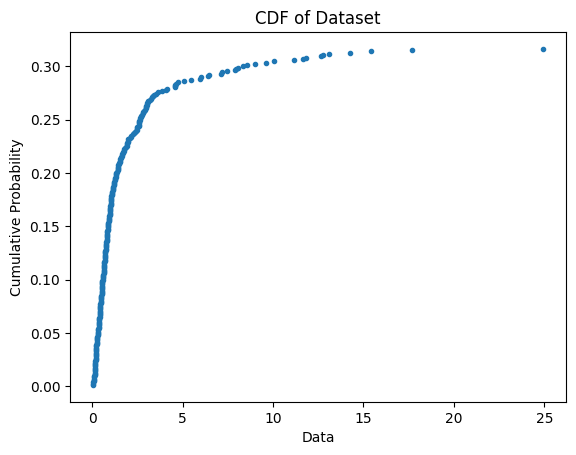

In [16]:
#chatgpt计算的图，明显好于上述几种
import numpy as np
import matplotlib.pyplot as plt
data = mean_coordinate.values
# calculate the CDF
x = np.sort(data)
y = np.arange(1, len(data)+1) / len(data)

# plot the CDF
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Data')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Dataset')
plt.show()

Run directly still. This is to extract the image name and x, y coordinates corresponding to each template.

In [17]:
# 提取出每个template对应的图片名字 以及x、y的坐标
template_name = []
template_x = []
template_y = []
for i in range(len(df)):
    if df['max_val_pre'][i] == 0:#max_val为0才是ifTemplate的本质特征
        template_name.append(df['filename'][i])
        template_x.append(df['x'][i])
        template_y.append(df['y'][i])
template_name
# df[df['ifTemplate'] == 1]['filename']
# template_x
# template_y

['bs0_ue00000.png',
 'bs0_ue00002.png',
 'bs0_ue00003.png',
 'bs0_ue00014.png',
 'bs0_ue00018.png',
 'bs0_ue00019.png',
 'bs0_ue00020.png',
 'bs0_ue00029.png',
 'bs0_ue00033.png',
 'bs0_ue00034.png',
 'bs0_ue00037.png',
 'bs0_ue00038.png',
 'bs0_ue00043.png',
 'bs0_ue00044.png',
 'bs0_ue00049.png',
 'bs0_ue00051.png',
 'bs0_ue00056.png',
 'bs0_ue00058.png',
 'bs0_ue00065.png',
 'bs0_ue00067.png',
 'bs0_ue00068.png',
 'bs0_ue00077.png',
 'bs0_ue00080.png',
 'bs0_ue00085.png',
 'bs0_ue00087.png',
 'bs0_ue00089.png',
 'bs0_ue00090.png',
 'bs0_ue00091.png',
 'bs0_ue00093.png',
 'bs0_ue00098.png',
 'bs0_ue00099.png',
 'bs0_ue00100.png',
 'bs0_ue00104.png',
 'bs0_ue00112.png',
 'bs0_ue00116.png',
 'bs0_ue00118.png',
 'bs0_ue00121.png',
 'bs0_ue00122.png',
 'bs0_ue00124.png',
 'bs0_ue00130.png',
 'bs0_ue00139.png',
 'bs0_ue00152.png',
 'bs0_ue00157.png',
 'bs0_ue00161.png',
 'bs0_ue00162.png',
 'bs0_ue00168.png',
 'bs0_ue00177.png',
 'bs0_ue00179.png',
 'bs0_ue00190.png',
 'bs0_ue00191.png',


In [18]:
len(template_name)

860

In [19]:
# 保存每个类以及对应的xy的mean，这里逻辑上是不对的，不过先通过均值看一看之后运算的结果的类别是否能够匹配上
mean_class_x = Recoder()
mean_class_y = Recoder()
idx_class = Recoder()
#initialize the templated
templated = []
#test
for idx in range(len(df['class'].unique())):
#     idx_class.update(df['class'].unique()[idx])
#     mean_class_x.update((df[df['class'] == df['class'].unique()[idx]]['x'].mean()))
#     mean_class_y.update((df[df['class'] == df['class'].unique()[idx]]['y'].mean()))
# mean_class_x.values
# mean_class_y.values
# idx_class.values
    
    templated.append((template_name[idx], df['class'].unique()[idx], df[df['class'] == df['class'].unique()[idx]]['x'].mean(), df[df['class'] == df['class'].unique()[idx]]['y'].mean()))
templated

[('bs0_ue00000.png', 0, 100.87161700842266, 52.50899706461222),
 ('bs0_ue00002.png', 1, 73.8505571076063, 30.773076523963347),
 ('bs0_ue00003.png', 2, 140.26625051042478, 52.22271280502514),
 ('bs0_ue00014.png', 3, 141.4526228597535, 34.23308663138503),
 ('bs0_ue00018.png', 4, 123.89984089570622, 48.48061064998807),
 ('bs0_ue00019.png', 5, 62.086663674869854, 32.058355455110245),
 ('bs0_ue00020.png', 6, 139.74630102058006, 55.61789741371294),
 ('bs0_ue00029.png', 7, 113.48839120842986, 56.28552415067335),
 ('bs0_ue00033.png', 8, 109.09256861928577, 49.9977169984821),
 ('bs0_ue00034.png', 9, 66.3356974953809, 31.891471316619697),
 ('bs0_ue00037.png', 10, 93.06914743224323, 54.14960590489052),
 ('bs0_ue00038.png', 11, 118.347162963532, 32.62858078772303),
 ('bs0_ue00043.png', 12, 77.59917454439112, 168.0170244559175),
 ('bs0_ue00044.png', 13, 97.01030660526744, 57.85208459507648),
 ('bs0_ue00049.png', 14, 76.48910543501954, 161.9279284176083),
 ('bs0_ue00051.png', 15, 134.73888849088112,

In [20]:
templated[0][0]

'bs0_ue00000.png'

Run directly still. Here is to store the template which is PFCFR image into new folder.

In [21]:
#将template的图片保存在新的文件夹里面
# #load the thresholds
# num_images = 1500
# sim_threshold = 0.55
# dist_threshold = 0.7
# stop_threshold = num_images+500
# template_size = 16
# #定义文件夹的地址
# path = "/workspace/wbh/DeepMIMO-5GNR/DeepMIMO_python/channel/withPhase_32*64_1500/"
# template_folder = 'template_' + str(template_size) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(dist_threshold)
# template_folder_loc = os.path.join('/workspace/wbh/DeepMIMO-5GNR/DeepMIMO_python/channel/', template_folder)
#如果文件夹已经存在，则跳过
if os.path.exists(template_folder_loc1):
    pass
else:
    #创建文件夹
    os.mkdir(template_folder_loc1)
    #在文件夹里面放图片
for i in tqdm(range(len(templated))):
    #打开图片
    img = cv2.imread(os.path.join(path, templated[i][0]))[:template_size_x, :template_size_y]
    cv2.imwrite(os.path.join(template_folder_loc1, templated[i][0]), img)
        
if os.path.exists(template_folder_loc2):
    pass
else:
    #创建文件夹
    os.mkdir(template_folder_loc2)
    #在文件夹里面放图片
for i in tqdm(range(len(templated))):
    #打开图片
    img = cv2.imread(os.path.join(path, templated[i][0]))[-template_size_x:, -template_size_y:]
    cv2.imwrite(os.path.join(template_folder_loc2, templated[i][0]), img)


100%|██████████| 860/860 [00:00<00:00, 4637.62it/s]


Run directly still. Calculate the best match between PFCFR one by one.

In [22]:
#已经跑过就不用跑了，直接读取csv文件。
#一一计算template之间的最佳匹配，并将对应的类别的所有图片赋值为同一类别。 
#each img has len(template_folder_loc) max_val
each_max_val = []
for i, img_name in enumerate(tqdm(template_name)):
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    x1 = template_x[i]
    y1 = template_y[i]
    for k, template_name_1 in enumerate(template_name):
        # Calculate the 1st similarity between the image and the template
        template_path1 = os.path.join(template_folder_loc1, template_name_1)
        template1 = cv2.imread(template_path1)       
        result1 = cv2.matchTemplate(img, template1, cv2.TM_CCORR_NORMED)
        min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(result1)
        # Calculate the 2nd similarity between the image and the template
        template_path2 = os.path.join(template_folder_loc2, template_name_1)
        template2 = cv2.imread(template_path2)       
        result2 = cv2.matchTemplate(img, template2, cv2.TM_CCORR_NORMED)
        min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(result2)
        #difference between the x and y of two templates
        x2 = template_x[k]
        y2 = template_y[k]       
        norm2_diff = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        each_max_val.append((img_name, template_name_1, round(max_val1,4), round(max_val2,4), round(norm2_diff,4)))
each_max_val
#列表转成df
df_each_max_val = pd.DataFrame(each_max_val, columns=['template1', 'template2', 'max_val_pre', 'max_val_pro', 'normdistance'])
#each_max_val代表的是[('3.png', '3.png', 1.0, 1.0, 0.0), ('3.png', '7.png', 0.9472, 0.9706, 0.8)......这样的模板之间的匹配程度以及它们的距离。
#我要将template分成几个类是根据它来判断。有两个更改值，组内相似度或者组间相似度。这个是组间相似度。
#tocsv
df_each_max_val.to_csv(os.path.join(savedatadir, 'each_max_val_' + str(sim_threshold) + '_' + template_result_file), index=False)
df_each_max_val

100%|██████████| 860/860 [03:37<00:00,  3.95it/s]


,template1,template2,max_val_pre,max_val_pro,normdistance
0,bs0_ue00000.png,bs0_ue00000.png,1.0000,1.0000,0.0000
1,bs0_ue00000.png,bs0_ue00002.png,0.8194,0.8893,33.0455
2,bs0_ue00000.png,bs0_ue00003.png,0.8205,0.8487,39.1533
3,bs0_ue00000.png,bs0_ue00014.png,0.7642,0.7637,43.0427
4,bs0_ue00000.png,bs0_ue00018.png,0.8063,0.7630,23.0334
...,...,...,...,...,...
739595,bs0_ue09987.png,bs0_ue09973.png,0.8950,0.8860,104.0376
739596,bs0_ue09987.png,bs0_ue09978.png,0.9912,0.9940,4.0845
739597,bs0_ue09987.png,bs0_ue09982.png,0.9538,0.9569,11.8471
739598,bs0_ue09987.png,bs0_ue09985.png,0.9133,0.8820,27.0401


In [23]:
#在更新了sim_threshold的值，已经跑过templatematching.py以及上述的话来跑这个
#从已经跑过的df_each_max_val读取出来，生成each_max_val
df_each_max_val = pd.read_csv(os.path.join(savedatadir, 'each_max_val_' + str(sim_threshold) + '_' + template_result_file))#, index_col=0)
each_max_val = df_each_max_val.values.tolist()
each_max_val

[['bs0_ue00000.png', 'bs0_ue00000.png', 1.0, 1.0, 0.0],
 ['bs0_ue00000.png', 'bs0_ue00002.png', 0.8194, 0.8893, 33.0455],
 ['bs0_ue00000.png', 'bs0_ue00003.png', 0.8205, 0.8487, 39.1533],
 ['bs0_ue00000.png', 'bs0_ue00014.png', 0.7642, 0.7637, 43.0427],
 ['bs0_ue00000.png', 'bs0_ue00018.png', 0.8063, 0.763, 23.0334],
 ['bs0_ue00000.png', 'bs0_ue00019.png', 0.8135, 0.8585, 42.8749],
 ['bs0_ue00000.png', 'bs0_ue00020.png', 0.8322, 0.8818, 39.0399],
 ['bs0_ue00000.png', 'bs0_ue00029.png', 0.8955, 0.9238, 14.1217],
 ['bs0_ue00000.png', 'bs0_ue00033.png', 0.9681, 0.9592, 8.7277],
 ['bs0_ue00000.png', 'bs0_ue00034.png', 0.7875, 0.8364, 40.549],
 ['bs0_ue00000.png', 'bs0_ue00037.png', 0.9597, 0.948, 9.5439],
 ['bs0_ue00000.png', 'bs0_ue00038.png', 0.8246, 0.8339, 23.8913],
 ['bs0_ue00000.png', 'bs0_ue00043.png', 0.7455, 0.7648, 121.0026],
 ['bs0_ue00000.png', 'bs0_ue00044.png', 0.9359, 0.9802, 9.5456],
 ['bs0_ue00000.png', 'bs0_ue00049.png', 0.741, 0.7377, 115.1985],
 ['bs0_ue00000.png', 'bs0

In [24]:
#将template_name转化成dataframe
mid_template = {"img_name": template_name}
df_template = pd.DataFrame(mid_template)
df_template

,img_name
0,bs0_ue00000.png
1,bs0_ue00002.png
2,bs0_ue00003.png
3,bs0_ue00014.png
4,bs0_ue00018.png
...,...
855,bs0_ue09973.png
856,bs0_ue09978.png
857,bs0_ue09982.png
858,bs0_ue09985.png


In [25]:
indices = df_template[df_template['img_name'].isin([each_max_val[1][0], each_max_val[1][1]])].index
indices

Index([0, 1], dtype='int64')

Run directly still. 

This is to group similar templates into the same category.

Assign all images corresponding to the category of each_max_val to the same class. Iterate through each row of each_max_val. If the values in the 3rd and 4th columns are both greater than 0.99, assign them to the same category. If the value in the 5th column is less than 1, then as long as one of the values in the 3rd or 4th columns is greater than 0.99, assign them to the same category. The principle for grouping into the same category is as follows: read the values in the 1st and 2nd columns of each row in each_max_val, treat them as a new list, and then increment the values in the 3rd column by 1, starting from 0.

In [26]:
# 将模板之间相似的归为同一类。
# 将each_max_val的对应的类别的所有图片赋值为同一类别。依次读取each_max_val的每一行，如果第3、4列的值都大于0.99，则把它们令为同一类别。如果第5列的值小于1，那么第3、4列只要有一个值大于0.99，就把它们令为同一类别。令为同一类别的原则为：读取each_max_val此行的第1、2列，将它们作为列表新的一列，然后在列表的第3列从0依次加1。
#define the value
template_name_class = []
ordered_value = 0
for i, image in enumerate(tqdm(template_name)):
    #新的图片令为新的类
#     mid_template[i][1] = classnum
    for k,_ in enumerate(each_max_val):
        # Check if the image is in columns 1 or 2
        if each_max_val[k][0] == image or each_max_val[k][1] == image:
            #判断是否是同一类
            if (each_max_val[k][2] >= sim_threshold_betweenTemp and each_max_val[k][3] >= sim_threshold_betweenTemp) or (each_max_val[k][4] <= std_avg and (each_max_val[k][2] >= sim_threshold_betweenTemp or each_max_val[k][3] >= sim_threshold_betweenTemp)):
                # Find the two image names in the first column of df_template
                indices = df_template[df_template['img_name'].isin([each_max_val[k][0], each_max_val[k][1]])].index
                
                #在dataframe当中创建第1列
                if 1 not in df_template.columns:
                    df_template[1] = num_images  
#                     df_template.columns = ["img_name", "classnum"]
                    

                #按照相似度进行分类
                if len(indices) == 1:#当第一列和第二列都是一样的时候
                    if df_template.loc[indices[0], 1] == num_images:
                        df_template.loc[indices, 1] = ordered_value
                        ordered_value += 1
                elif len(indices) == 2:
                    # Check if any value exists in the column
                    if df_template.loc[indices[0], 1] != num_images:
                        # Set the other row to the same value
                        df_template.loc[indices[1], 1] = df_template.loc[indices[0], 1]
                    elif df_template.loc[indices[1], 1] != num_images:
                        # Set the other row to the same value
                        df_template.loc[indices[0], 1] = df_template.loc[indices[1], 1]
                    else:
                        # Set the values of both rows to the ordered value
                        df_template.loc[indices, 1] = ordered_value
                        ordered_value += 1
    #                 elif len(indices) == 1:
                               
df_template            

  0%|          | 0/860 [00:00<?, ?it/s]

100%|██████████| 860/860 [02:45<00:00,  5.19it/s]


,img_name,1
0,bs0_ue00000.png,0
1,bs0_ue00002.png,1
2,bs0_ue00003.png,2
3,bs0_ue00014.png,3
4,bs0_ue00018.png,4
...,...,...
855,bs0_ue09973.png,122
856,bs0_ue09978.png,2
857,bs0_ue09982.png,2
858,bs0_ue09985.png,2


In [27]:
df_template

,img_name,1
0,bs0_ue00000.png,0
1,bs0_ue00002.png,1
2,bs0_ue00003.png,2
3,bs0_ue00014.png,3
4,bs0_ue00018.png,4
...,...,...
855,bs0_ue09973.png,122
856,bs0_ue09978.png,2
857,bs0_ue09982.png,2
858,bs0_ue09985.png,2


In [696]:
# # Wrong program without bugging for lots of time running. 
# # 错误的程序。时间需要的过大。
# # 将模板之间相似的归为同一类。
# # 将each_max_val的对应的类别的所有图片赋值为同一类别。依次读取each_max_val的每一行，如果第3、4列的值都大于0.99，则把它们令为同一类别。如果第5列的值小于1，那么第3、4列只要有一个值大于0.99，就把它们令为同一类别。令为同一类别的原则为：读取each_max_val此行的第1、2列，将它们作为列表新的一列，然后在列表的第3列从0依次加1。
# #define the value
# template_name_class = []
# ordered_value = 0
# for i, image in enumerate(tqdm(template_name)):
#     #新的图片令为新的类
# #     mid_template[i][1] = classnum
#     for k, each_max_val in df_each_max_val.iterrows():
#         # Check if the image is in columns 1 or 2
#         if each_max_val['template1'] == image or each_max_val['template2'] == image:
#             #判断是否是同一类
#             if (float(each_max_val['max_val_pre']) > sim_threshold_betweenTemp and float(each_max_val['max_val_pro']) > sim_threshold_betweenTemp) or (each_max_val['normdistance'] <= 1 and (float(each_max_val['max_val_pre']) > sim_threshold_betweenTemp or float(each_max_val['max_val_pro']) > sim_threshold_betweenTemp)):
#                 # Find the two image names in the first column of df_template
#                 indices = df_template[df_template['img_name'].isin([each_max_val['template1'], each_max_val['template2']])].index
                
#                 #在dataframe当中创建第1列
#                 if 1 not in df_template.columns:
#                     df_template[1] = num_images  
# #                     df_template.columns = ["img_name", "classnum"]
                    

#                 #按照相似度进行分类
#                 if len(indices) == 1:
#                     if df_template.loc[indices[0], 1] == num_images:
#                         df_template.loc[indices, 1] = ordered_value
#                         ordered_value += 1
#                 elif len(indices) == 2:
#                     # Check if any value exists in the column
#                     if df_template.loc[indices[0], 1] != num_images:
#                         # Set the other row to the same value
#                         df_template.loc[indices[1], 1] = df_template.loc[indices[0], 1]
#                     elif df_template.loc[indices[1], 1] != num_images:
#                         # Set the other row to the same value
#                         df_template.loc[indices[0], 1] = df_template.loc[indices[1], 1]
#                     else:
#                         # Set the values of both rows to the ordered value
#                         df_template.loc[indices, 1] = ordered_value
#                         ordered_value += 1
#     #                 elif len(indices) == 1:
                    
                
# df_template            

Run directly still. Update the new df according to the new classification value df_template.

In [28]:
# 按照df_template的新分类值更新出新的df。
# Read the first column of each row of df_template in sequence
for i, row in df_template.iterrows():
    # Get the image name and category from the row
    image = row['img_name']
    category = row[1]

    # Find the matching rows in df['class']
#     matching_rows = df.loc[df['class'] == category, 'filename']
    target_class = df.loc[df['filename'] == image, 'class'].values[0]
    matched_indices = df.loc[df['class'] == target_class].index
    df.loc[matched_indices, 'class'] = category

# if not os.path.exists(template_result_file_aftersimilarity):
#     os.makedirs(template_result_file_aftersimilarity)

df

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate
0,bs0_ue00000.png,0,101.223205,49.286445,0.000000,0.000000,1
1,bs0_ue00111.png,0,103.788684,51.437515,0.992635,0.994101,0
2,bs0_ue00354.png,0,101.855685,54.052225,0.995231,0.995569,2
3,bs0_ue00993.png,0,102.175603,54.580972,0.994201,0.995713,0
4,bs0_ue01305.png,0,102.331557,56.246922,0.999079,0.998423,0
...,...,...,...,...,...,...,...
2282,bs0_ue09973.png,122,70.934721,151.116000,0.000000,0.000000,1
2283,bs0_ue09978.png,2,115.859571,59.039773,0.000000,0.000000,1
2284,bs0_ue09982.png,2,124.184034,51.786785,0.000000,0.000000,1
2285,bs0_ue09985.png,2,139.902672,59.710598,0.000000,0.000000,1


Run directly still. 

Assign class[0,3,5...]->[0,1,2...], and save it as a .csv file. 

In [29]:
#Assign class[0,3,5...]->[0,1,2...]，并保存为csv文件
df2 = df.copy(deep=True)
for i, row in df.iterrows():
    df2.loc[i, 'class'] = range(len(df['class'].unique()))[df['class'].unique().tolist().index(row['class'])]
df2.to_csv(template_result_file_aftersimilarity, index=False)
df2

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate
0,bs0_ue00000.png,0,101.223205,49.286445,0.000000,0.000000,1
1,bs0_ue00111.png,0,103.788684,51.437515,0.992635,0.994101,0
2,bs0_ue00354.png,0,101.855685,54.052225,0.995231,0.995569,2
3,bs0_ue00993.png,0,102.175603,54.580972,0.994201,0.995713,0
4,bs0_ue01305.png,0,102.331557,56.246922,0.999079,0.998423,0
...,...,...,...,...,...,...,...
2282,bs0_ue09973.png,122,70.934721,151.116000,0.000000,0.000000,1
2283,bs0_ue09978.png,2,115.859571,59.039773,0.000000,0.000000,1
2284,bs0_ue09982.png,2,124.184034,51.786785,0.000000,0.000000,1
2285,bs0_ue09985.png,2,139.902672,59.710598,0.000000,0.000000,1


In [1]:
df2

NameError: name 'df2' is not defined

In [671]:
SNR

35

Now we need open the `template_result_file_aftersimilarity` file and the `targetfile_nlos` file. Assign the values of `angle1`, `angle2`, `distance`, and `gain` from `targetfile_nlos` to the corresponding last four columns of `template_result_file_aftersimilarity` based on matching image names. 

To save time, the method I used to extract `distance` and `pathloss` is as follows: the primary keyword is `x`, the secondary keyword is `y`, and they are sorted in descending order. Afterward, locate the pre-processed CSV file, ensuring both sides are sorted consistently, and directly copy and paste the data. 

Additionally, after processing, convert the `class` list into a continuous form.

The final processed `template_result_file_aftersimilarity` file has the format shown in the figure below.


![这是图片](images_git/5.jpg "5")

In [137]:
# #这一段程序就可以不用跑了。59000的数据要跑12分钟。
# #如果没有distance和pathloss列，就创建新列
# df['distance'] = pd.Series()
# df['pathloss'] = pd.Series()
# #给df末尾增加两列distance和pathloss
# #由于不好操作，我增加了target_1500.txt里面最后两列的distance和pathloss，所以df之后也应该有两列。但是df的产生经过了不少流程，所以直接在这里产生，就不回到原始的地方产生了。
# #打开txt文件
# lines = open('/workspace/wbh/DeepMIMO_python/data/label/target.txt', 'r').readlines()
# for i, row in tqdm(df.iterrows(), total=df.shape[0]):
#     image = row['filename']
#     for line in lines:
#         image_path, ueloc_x, ueloc_y, distance, pathloss = line.strip().split(',')#txt读取
#         if image == image_path:
#             df.loc[i, 'distance'] = distance
#             df.loc[i, 'pathloss'] = pathloss
#             break   
# #将此时的df存入template
# df.to_csv(template_result_file)
# df

/tmp/ipykernel_116757/1129592281.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['distance'] = pd.Series()
/tmp/ipykernel_116757/1129592281.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['pathloss'] = pd.Series()


After we reprocessed the `template_result_file_aftersimilarity` file, continue running the following program.

In [7]:
#上述步骤后正常运行该步骤
# 如果断连；之后有程序是将有Pathloss和distance的值存入tempalte_result_file的
df = pd.read_csv(template_result_file_aftersimilarity)
df

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain
0,bs0_ue05101.png,95,36.597599,137.445470,0.994966,0.996179,0,-0.372043,0.266670,0.395237,0.574604
1,bs0_ue03369.png,95,37.514706,133.959868,0.998384,0.998347,0,-0.372043,0.273708,0.374403,0.592675
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379
...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050
2285,bs0_ue01612.png,12,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559


In [8]:
len(df['class'].unique())

123

In [9]:
df['class'].unique()

array([ 95,   1,  36,   5,  23,  88,  31,  18, 111,  19,  67,  22,  85,
        51, 122, 108, 116,  77,  98, 118, 100, 112,  11,  60,  10, 120,
        29, 107,  56,  38,  82,  93,  92,  44,  15,  59, 115,  72,  33,
        86,  74,  91,  81,  13,  79, 117,   8,  17,  42,  66,  54,   0,
       102, 104,  84,   7,  99,  68,  52,  69,  65,  46,  70, 101,   2,
        34,  53,  14,  57,  30,  90,  43,  48,  58, 103,  97,  96,  32,
        26,  41,  71,  45,  49,  12,  16,  55,  61,   6,  20,  47,  39,
       105,   4,   9, 109,  75, 114, 106, 110, 113,  94,  28,  83,  24,
        37,  64,  76,   3,  73,  27,  62,  89,  63,  21,  80,  87,  78,
        25,  40, 121,  35,  50, 119])

In [10]:
df[df['class'] == 17]

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain
582,bs0_ue02199.png,17,85.858768,36.198198,0.995135,0.994837,0,0.140205,0.942746,0.290873,0.665761
585,bs0_ue07231.png,17,85.994048,37.376311,0.997550,0.996965,0,0.140205,0.939887,0.284076,0.664365
587,bs0_ue07290.png,17,86.149212,33.732574,0.997860,0.998290,0,0.140205,0.938226,0.305128,0.664544
591,bs0_ue08412.png,17,86.395476,44.314155,0.992440,0.991546,0,0.140205,0.899824,0.244372,0.645119
678,bs0_ue03123.png,17,92.390118,40.690524,0.000000,0.000000,1,0.138772,0.919212,0.283038,0.615172
679,bs0_ue06757.png,17,92.419397,34.729914,0.998783,0.998665,0,0.138772,0.938038,0.317428,0.676612
681,bs0_ue04316.png,17,92.526092,38.840794,0.000000,0.000000,1,0.138772,0.924611,0.293742,0.672829
684,bs0_ue05506.png,17,92.597746,38.744595,0.999642,0.999805,0,0.138772,0.920499,0.294336,0.672320
690,bs0_ue01012.png,17,92.903763,35.397834,0.000000,0.000000,1,0.138772,0.922459,0.313745,0.672179
691,bs0_ue01871.png,17,92.975049,35.805755,0.999058,0.998941,0,0.138772,0.918746,0.311447,0.671234


Run directly still. 

This is to print the image number in the class

In [11]:
#打印image number in the class
num_image = []#image number in the class
for i in range(len(df['class'].unique())):
    num_image.append([i, len(df[df['class'] == i])])
num_image

[[0, 28],
 [1, 93],
 [2, 344],
 [3, 20],
 [4, 40],
 [5, 54],
 [6, 25],
 [7, 128],
 [8, 211],
 [9, 14],
 [10, 20],
 [11, 24],
 [12, 116],
 [13, 8],
 [14, 37],
 [15, 5],
 [16, 31],
 [17, 17],
 [18, 31],
 [19, 53],
 [20, 11],
 [21, 8],
 [22, 3],
 [23, 67],
 [24, 6],
 [25, 47],
 [26, 8],
 [27, 61],
 [28, 2],
 [29, 10],
 [30, 10],
 [31, 22],
 [32, 11],
 [33, 38],
 [34, 48],
 [35, 1],
 [36, 17],
 [37, 42],
 [38, 16],
 [39, 3],
 [40, 20],
 [41, 20],
 [42, 1],
 [43, 7],
 [44, 5],
 [45, 7],
 [46, 1],
 [47, 13],
 [48, 38],
 [49, 9],
 [50, 3],
 [51, 8],
 [52, 2],
 [53, 28],
 [54, 3],
 [55, 16],
 [56, 1],
 [57, 32],
 [58, 11],
 [59, 7],
 [60, 27],
 [61, 9],
 [62, 2],
 [63, 2],
 [64, 1],
 [65, 2],
 [66, 7],
 [67, 7],
 [68, 26],
 [69, 6],
 [70, 14],
 [71, 6],
 [72, 2],
 [73, 1],
 [74, 3],
 [75, 2],
 [76, 2],
 [77, 5],
 [78, 20],
 [79, 8],
 [80, 9],
 [81, 3],
 [82, 23],
 [83, 1],
 [84, 6],
 [85, 5],
 [86, 2],
 [87, 17],
 [88, 6],
 [89, 3],
 [90, 5],
 [91, 8],
 [92, 3],
 [93, 6],
 [94, 4],
 [95, 4],
 

In [848]:
# # 比较同一类别里面的图片的模式识别max_val，然后发现当df['class']=0时，小于0.1的概率出现0.95<=max_val<=0.999的情况（排除两个template是同一张图），即非常相近。
# # 我想看一看，比如df['class']=0时候的所有图片当中，有没有两张图片本身高度相似的情况出现？
# # Define the path to the image folder
# # path = '/workspace/wbh/DeepMIMO-5GNR/DeepMIMO_python/channel/withPhase_32*64_1500'
# # Initialize the list of classified images
# classified_inner = []
# # define the value to debug。通过更改classnum1的值，观察最终的结果
# classnum1 = 0 #class的num from 0-6
# similarity1 = 0.95
# for i, line in tqdm(df[df['class'] == classnum1].iterrows(), total=df[df['class'] == classnum1].shape[0]):
# #     targets.append((float(line['x']), float(line['y'])))
#     imgname = line['filename']
#     template1 = cv2.imread(os.path.join(path, imgname))
#     x1 = line['x']
#     y1 = line['y']
#     distance1 = line['distance']
#     pathloss1 = line['gain']
#     # Loop through all the remaining image files in the folder
#     for j, line2 in df[df['class'] == classnum1].iterrows():
#         filename = line2['filename']
#         img = cv2.imread(os.path.join(path, filename))
#         x2 = line2['x']
#         y2 = line2['y']
#         distance2 = line2['distance']
#         pathloss2 = line2['gain']
#         result1 = cv2.matchTemplate(img, template1, cv2.TM_CCOEFF_NORMED)
#         _, max_val1, _, _ = cv2.minMaxLoc(result1)
#         classified_inner.append([imgname, filename, max_val1, x1, y1, x2, y2,distance1,pathloss1,distance2,pathloss2])
# classified_inner
# df_classified_inner = pd.DataFrame(classified_inner,columns=['imgname','filename','max_val','x1','y1','x2','y2','distance1','gain1','distance2','gain2'])
# df_classified_inner
# # print('The probability of the images in one class with high similarity is {:.2%}'.format(len(df_classified_inner[df_classified_inner['max_val'] >= similarity1]) / len(df[df['class'] == classnum1]) ** 2))
# print('The probability of the images in one class with high similarity is {:.2%}'.format(len(df_classified_inner[df_classified_inner['max_val'].between(similarity1, 0.999)]) / len(df[df['class'] == classnum1]) ** 2))
# # df_classified_inner[df_classified_inner['max_val'] >= similarity1]
# df_2similar = df_classified_inner[df_classified_inner['max_val'].between(similarity1, 0.999)]
# df_2similar.to_csv('df_2similar'  + template_result_file)
# df_2similar

/tmp/ipykernel_199277/706920715.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', 43)


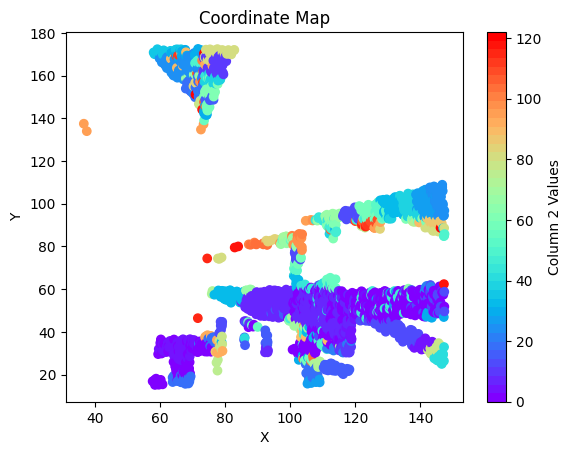

In [12]:
#可视化场景图及分类
x = df.iloc[:, 2].round(2)
y = df.iloc[:, 3].round(2)
colors = df.iloc[:, 1]

# Set up the color map
cmap = plt.cm.get_cmap('rainbow', 43)

# Create a scatter plot
plt.scatter(x, y, c=colors, cmap=cmap)
# plt.scatter(y, x, c=colors, cmap=cmap)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Column 2 Values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlabel('Y')
# plt.ylabel('X')
plt.title('Coordinate Map')

# Display the plot
plt.show()


In [850]:
df

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain
0,bs0_ue05101.png,0,36.597599,137.445470,0.000000,0.000000,1,-0.372043,0.266670,0.395237,0.574604
1,bs0_ue03369.png,0,37.514706,133.959868,0.000000,0.000000,1,-0.372043,0.273708,0.374403,0.592675
2,bs0_ue02761.png,1,57.751648,16.838119,0.000000,0.000000,1,0.307293,0.917609,0.322061,0.591990
3,bs0_ue04668.png,0,58.055440,170.830140,0.000000,0.000000,1,-0.077711,0.209148,0.830700,0.763588
4,bs0_ue08660.png,0,58.330877,170.015790,0.997923,0.997954,0,-0.077711,0.208773,0.825818,0.763379
...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,48,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286
2283,bs0_ue03738.png,0,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555
2284,bs0_ue07036.png,0,147.410191,96.759397,0.999427,0.999432,0,-0.077711,0.605895,0.556136,0.661050
2285,bs0_ue01612.png,0,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559


You could choose to run this to calculate the pixel distribution of grayscale images

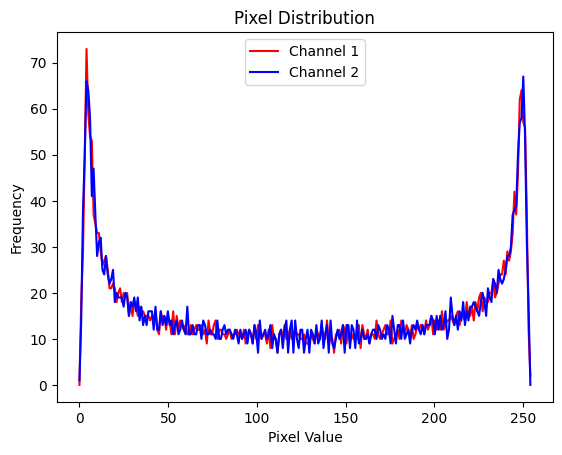

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = generatedFolder + '/bs0_ue00014.png'
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Check if the image has 2 channels
if image_array.shape[-1] != 2:
    raise ValueError("The image must have 2 channels")

# Extract the two channels
channel_1 = image_array[:, :, 0]
channel_2 = image_array[:, :, 1]

# Calculate the pixel distribution for each channel
channel_1_distribution = np.histogram(channel_1.flatten(), bins=256, range=[0, 255])
channel_2_distribution = np.histogram(channel_2.flatten(), bins=256, range=[0, 255])

# Plot the pixel distribution
fig, ax = plt.subplots()
ax.plot(channel_1_distribution[1][:-1], channel_1_distribution[0], color='red', label='Channel 1')
ax.plot(channel_2_distribution[1][:-1], channel_2_distribution[0], color='blue', label='Channel 2')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.set_title('Pixel Distribution')
ax.legend()

# Display the plot
plt.show()


In [120]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Input and output directories
# input_directory = '/workspace/wbh/DeepMIMO-5GNR-localpycharm/data/scenario_2_00032_1500'
output_directory = distribution_folder_loc

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Get a list of image files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

for image_file in tqdm(image_files):
    # Load the image
    image_path = os.path.join(input_directory, image_file)
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Check if the image has 2 channels
    if image_array.shape[-1] != 2:
        raise ValueError("The image must have 2 channels")

    # Extract the two channels
    channel_1 = image_array[:, :, 0]
    channel_2 = image_array[:, :, 1]

    # Calculate the pixel distribution for each channel
    channel_1_distribution = np.histogram(channel_1.flatten(), bins=256, range=[0, 255])
    channel_2_distribution = np.histogram(channel_2.flatten(), bins=256, range=[0, 255])

    # Plot the pixel distribution
    fig, ax = plt.subplots()
    ax.plot(channel_1_distribution[1][:-1], channel_1_distribution[0], color='red', label='Channel 1')
    ax.plot(channel_2_distribution[1][:-1], channel_2_distribution[0], color='blue', label='Channel 2')
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Pixel Distribution')
    ax.legend()

    # Save the plot
    output_path = os.path.join(output_directory, image_file)
    plt.savefig(output_path)

    # Close the plot to release memory
    plt.close()

#     print(f"Pixel distribution saved for {image_file}")

print("Pixel distribution saved for all images.")


100%|██████████| 1453/1453 [02:09<00:00, 11.25it/s]

Pixel distribution saved for all images.


In [14]:
#打开几张图看看
image_path1 = os.path.join(input_directory, 'bs0_ue07696.png')
image1 = Image.open(image_path1)
image_path2 = os.path.join(input_directory, 'bs0_ue04630.png')
image2 = Image.open(image_path2)
#子图1
plt.subplot(121)
plt.imshow(image1)
plt.title('bs0_ue07696')
#不显示坐标轴
plt.axis('off')
#子图2
plt.subplot(122)
plt.imshow(image2)
plt.title('bs0_ue04630')
#不显示坐标轴
plt.axis('off')
# #设置子图默认的间距
plt.tight_layout()
#显示图像
plt.show()

NameError: name 'input_directory' is not defined

### Step 2: Process angle, gain, and other table data information

***Relevant clustering algorithms***


In [15]:
#读取数据
df_temp = pd.read_csv(template_result_file_aftersimilarity)
df_temp1 = df_temp[['filename', 'angle1', 'angle2', 'distance', 'gain']]
features = df_temp[['angle1', 'angle2', 'distance', 'gain']]
features

,angle1,angle2,distance,gain
0,-0.372043,0.266670,0.395237,0.574604
1,-0.372043,0.273708,0.374403,0.592675
2,0.307293,0.917609,0.322061,0.591990
3,-0.077711,0.209148,0.830700,0.763588
4,-0.077711,0.208773,0.825818,0.763379
...,...,...,...,...
2282,0.140205,0.589695,0.592615,0.706286
2283,0.124541,0.650099,0.557422,0.676555
2284,-0.077711,0.605895,0.556136,0.661050
2285,0.124541,0.656041,0.559041,0.674559


In [468]:
# '''
# 利用scipy进行层次聚类，将path当中的所有图片，每张图片拉平作为特征向量，进行euclidean距离计算，最后输出层次聚类树图，并将树图的横坐标读取出来
# '''
# import os
# import scipy.cluster.hierarchy as hcluster
# from PIL import Image
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import csv

# #计算距离矩阵
# disMat = hcluster.distance.pdist(features, metric='euclidean')

# # 进行层次聚类: 计算距离的方法使用 ward 法
# tree = hcluster.linkage(disMat, method='ward')
# # 将层级聚类结果以树状图表示出来并保存
# # 需要手动添加标签。
# plt.figure(figsize=(240, 12)) #画布大小
# plt.title('Dendrogram of Channel',fontdict={'size':21})
# labels = np.arange(1453)
# P = hcluster.dendrogram(tree, labels=labels)
# # P = hcluster.dendrogram(tree, labels=list(range(0,1452+1)))
# plt.xlabel('Figures',fontsize=14)
# plt.ylabel('Euclidean',fontsize=14)
# plt.xticks(color='black',rotation=90,verticalalignment='top',horizontalalignment='left') #进一步更改x轴标签
# plt.tick_params(axis='x',direction='out',length=4,width=2,pad=4,labelsize=9)
# plt.savefig('results/聚类结果1.png')
# #获取刻度标签
# foo = plt.xticks()
# print("xticks()刻度标签为", foo)
# print(int(float(str(foo[1]))))


# #features写入csv
# # np.savetxt( "features.csv", features, delimiter=" " )

# #tree写入csv
# # tree.to_csv("0.csv",index=False,sep=',')
# # with open('0.csv', 'w+', newline='') as csv_file:
# #     writer = csv.writer(csv_file)
# #     for row in tree:
# #         writer.writerow(row)

# # p = hcluster.fcluster(tree,  3, criterion='maxclust')
# # print(p)

Run directly still. 

Elbow method+contour coefficient method

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:09<00:00,  5.22it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHe

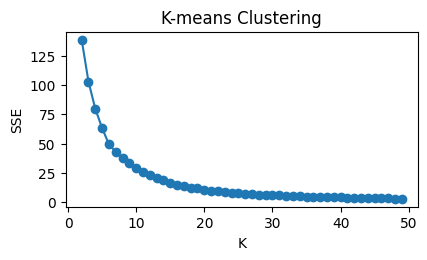

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

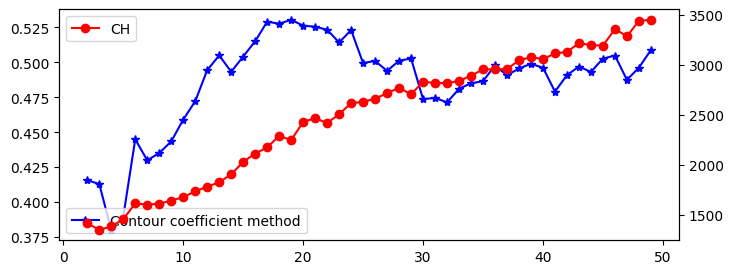

In [16]:
#手肘法+轮廓系数法
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import pandas as pd 
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from tqdm import trange

warnings.filterwarnings('ignore')


plt.rcParams['font.sans-serif']=['SimHei']##中文乱码问题！
plt.rcParams['axes.unicode_minus']=False#横坐标负号显示问题！


def choose_k(x):
    
    al = 50
    sse = []
    sc = []
    sc2 = []
    for k in trange(2, al):
        estimator = KMeans(n_clusters= k, random_state= 1, n_init= 20).fit(x)
        sse.append(estimator.inertia_)   # 手肘法
    
        scor = metrics.silhouette_score(x, estimator.labels_, sample_size=10000, metric= 'euclidean') # 轮廓系数法
        sc.append(scor)
        
        pred = estimator.predict(x)
        sc2.append(metrics.calinski_harabasz_score(x, pred))
#     print(sse)
    
    plt.figure(figsize=(10,5))
    plt.subplot(2, 2, 1)
    plt.plot(range(2, al), sse, 'o-', label = 'Elbow method')
#     plt.axhline( color= 'k', linestyle= '--', linewidth= 1)
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.xticks(fontsize = 10)
    plt.title('K-means Clustering')
    plt.savefig('results/Elbow method_loc.png')
    

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1, 1, 1)
    
    ax1.plot(range(2, al), sc, marker='*', color ='b',label = 'Contour coefficient method')
    ax1.legend(loc = 'lower left')
    
    ax2 = ax1.twinx()
    ax2.plot(range(2, al), sc2, marker ='o',color='r', label = 'CH')
    ax2.legend()
    plt.savefig('results/Contour coefficient method+CH_loc.png')


# In[2]:

# x = df[['ueLocx', 'ueLocy', 'distance', 'angle1', 'angle2']]
# x = df[['ueLocx', 'ueLocy']]
choose_k(features)

Run directly still. 

Kmeans.

In [17]:
#kmeans
k = 30#00743NLOS、NLOS+LOS
# k = 2#00743LOS
# k = 5#00247NLOS
# k = 7#00670NLOS
from sklearn.cluster import KMeans
from sklearn import preprocessing
#读取数据
train_x = features
# 建立模型  设置为k个簇
k_model = KMeans(n_clusters=k)
# 数据归一化
min_max_scaler = preprocessing.MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
# 训练模型
k_model.fit(train_x)
predict_y = k_model.predict(train_x)
predict_y
df_temp['kmeans'] = predict_y
#存成csv
df_temp.to_csv(template_result_file_aftersimilarity_kmeans, index=False)
df_temp

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans
0,bs0_ue05101.png,95,36.597599,137.445470,0.994966,0.996179,0,-0.372043,0.266670,0.395237,0.574604,26
1,bs0_ue03369.png,95,37.514706,133.959868,0.998384,0.998347,0,-0.372043,0.273708,0.374403,0.592675,26
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24
2285,bs0_ue01612.png,12,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559,7


If disconnected, or if the corresponding file already exists, skip the generation above and run the following code to read the file.

In [822]:
#断连或者已经有这个对应文件了或者怎么，直接打开
df_temp = pd.read_csv(template_result_file_aftersimilarity_kmeans)
df_temp

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans
0,bs0_ue05101.png,0,36.597599,137.445470,0.000000,0.000000,1,-0.372043,0.266670,0.395237,0.574604,25
1,bs0_ue03369.png,0,37.514706,133.959868,0.957143,0.962187,0,-0.372043,0.273708,0.374403,0.592675,25
2,bs0_ue02761.png,1,57.751648,16.838119,0.000000,0.000000,1,0.307293,0.917609,0.322061,0.591990,22
3,bs0_ue04668.png,2,58.055440,170.830140,0.000000,0.000000,1,-0.077711,0.209148,0.830700,0.763588,0
4,bs0_ue08660.png,2,58.330877,170.015790,0.997923,0.997954,0,-0.077711,0.208773,0.825818,0.763379,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,53,147.390388,58.757408,0.835789,0.829812,0,0.140205,0.589695,0.592615,0.706286,21
2283,bs0_ue03738.png,33,147.409482,51.804060,0.921122,0.926241,0,0.124541,0.650099,0.557422,0.676555,27
2284,bs0_ue07036.png,55,147.410191,96.759397,0.904177,0.902097,0,-0.077711,0.605895,0.556136,0.661050,19
2285,bs0_ue01612.png,33,147.410850,49.550462,0.887461,0.883704,0,0.124541,0.656041,0.559041,0.674559,27


In [791]:
# #没用上的自写的kmeans函数
# # kmeans
# import random
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# " 计算质心到点的距离"
# def calcDis(dataSet, centroids, k):
#     clalist=[]
#     for data in dataSet:
#         diff = np.tile(data, (k, 1)) - centroids  #相减   (np.tile(a,(2,1))就是把a先沿x轴复制1倍，即没有复制，仍然是 [0,1,2]。 再把结果沿y方向复制2倍得到array([[0,1,2],[0,1,2]]))
#         squaredDiff = diff ** 2     #平方
#         squaredDist = np.sum(squaredDiff, axis=1)   #和  (axis=1表示行)
#         distance = squaredDist ** 0.5  #开根号
#         clalist.append(distance) 
#     clalist = np.array(clalist)  #返回一个每个点到质点的距离len(dateSet)*k的数组

#     return clalist
# """ 计算质心，求出样本属于哪一个簇 """
# def classify(dataSet, centroids, k):
#     # 计算样本到质心的距离
#     clalist = calcDis(dataSet, centroids, k)
#     # 分组并计算新的质心
#     minDistIndices = np.argmin(clalist, axis=1)    #axis=1 表示求出每行的最小值的下标   
#     newCentroids = pd.DataFrame(dataSet).groupby(minDistIndices).mean() #DataFramte(dataSet)对DataSet分组，groupby(min)按照min进行统计分类，mean()对分类结果求均值
#     newCentroids = newCentroids.values
#     # 计算变化量
#     changed = newCentroids - centroids
 
#     return changed, newCentroids
# """ 点的簇分布 --> 展示出来"""
# def showCluster(cluster): 
    
#     """
#     绘制样本点
#     """
#     # 用不同颜色形状来表示各个类别
#     mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']  
    
#     for i,points in enumerate(cluster):   # 取出簇
#         # 因为同一个簇的需要绘制同样的颜色，所以需要得到同一个簇的索引
#         markIndex = int(i)  
#         for point in points :    # 取出属于簇中的每个样本点
#             plt.plot(point[0],point[1],mark[markIndex])
    
#     """
#     绘制质心点
#     """
#     # 用不同颜色形状来表示各个类别
#     mark = ['*r', '*b', '*g', '*k', '^b', '+b', 'sb', 'db', '<b', 'pb'] 
    
#     # 绘制质心点
#     for j in range(len(centroids)):
#         plt.plot(centroids[j][0],centroids[j][1],mark[j], markersize = 20)
#         plt.show
# """封装并 使用k-means分类"""
# def kmeans(dataSet, k):
#     # 随机取质心
#     centroids = random.sample(dataSet, k)
    
#     # 更新质心 直到变化量全为0
#     changed, newCentroids = classify(dataSet, centroids, k)
#     while np.any(changed != 0):
#         changed, newCentroids = classify(dataSet, newCentroids, k)
 
#     centroids = sorted(newCentroids.tolist())   #tolist()将矩阵转换成列表 sorted()排序
 
#     # 根据质心计算每个集群
#     cluster = []
#     clalist = calcDis(dataSet, centroids, k) #调用欧拉距离
#     minDistIndices = np.argmin(clalist, axis=1)

#     for i in range(k):
#         cluster.append([])
#     for i, j in enumerate(minDistIndices):   #enumerate()可同时遍历索引和遍历元素 i对应索引，j对应元素（0,...,k-1），而元素对应的刚好是k
#         cluster[j].append(dataSet[i])
    
#     # 展示点的簇分布
#     showCluster(cluster)
    
#     # 计算平均损失，判断不同k的分类效果
#     minDistance = np.min(clalist, axis=1)    # axis=1 表示求出每行的最小值 
#     loss = np.mean(minDistance)   # # 计算距离变化值（损失）  样本跟它所属簇的误差求和/样本个数-->平均损失
    
#     return centroids, cluster,loss
# """创建数据集 """
# def createDataSet():
#     data = features.values
#     plt.scatter(data[:,0],data[:,1])#,data[:,2],data[:,3])
#     plt.show()
#     data = np.array(data)
#     data = data.tolist()
#     return data
    
# if __name__=='__main__': 
#     dataset = createDataSet()
    
#     # 存储每个k值下的损失
#     loss_list = []
    
#     for k in range(2,10):  # k的范围在2，9
#         centroids, cluster,loss = kmeans(dataset, k)
# #         print('质心为：%s' % centroids)
# #         print('集群为：%s' % cluster)
#         loss_list.append(loss)
    

#     # 观察k值与损失的关系
#     plt.figure(figsize=(8,6))
#     plt.plot(range(2,9),loss_list)  # 绘制不同k下的效果
#     plt.xlabel('k')
#     plt.ylabel("loss")
#     plt.show()


Run directly still. 

Print image number in the class

In [18]:
#打印image number in the class
num_image = []#image number in the class
for i in range(len(df_temp['kmeans'].unique())):
    num_image.append([i, len(df_temp[df_temp['kmeans'] == i])])
num_image

[[0, 32],
 [1, 220],
 [2, 70],
 [3, 28],
 [4, 61],
 [5, 10],
 [6, 62],
 [7, 208],
 [8, 137],
 [9, 63],
 [10, 57],
 [11, 125],
 [12, 77],
 [13, 117],
 [14, 15],
 [15, 60],
 [16, 57],
 [17, 10],
 [18, 32],
 [19, 34],
 [20, 79],
 [21, 107],
 [22, 112],
 [23, 11],
 [24, 206],
 [25, 6],
 [26, 4],
 [27, 242],
 [28, 22],
 [29, 23]]

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

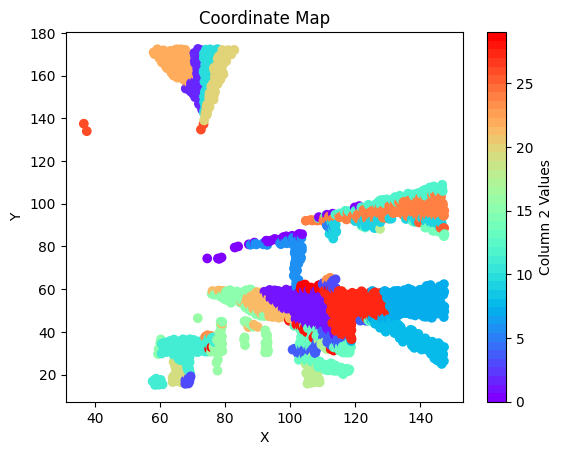

In [19]:
#可视化kmeans场景图及分类
x = df_temp.iloc[:, 2].round(2)
y = df_temp.iloc[:, 3].round(2)
colors = df_temp.iloc[:, 11]

# Set up the color map
cmap = plt.cm.get_cmap('rainbow', 43)

# Create a scatter plot
plt.scatter(x, y, c=colors, cmap=cmap)
# plt.scatter(y, x, c=colors, cmap=cmap)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Column 2 Values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlabel('Y')
# plt.ylabel('X')
plt.title('Coordinate Map')

# Display the plot
plt.show()


In [20]:
df_temp[['class', 'kmeans']]

,class,kmeans
0,95,26
1,95,26
2,1,11
3,36,22
4,36,22
...,...,...
2282,12,7
2283,2,7
2284,25,24
2285,12,7


In [21]:
import pandas as pd

# Example dataframe 'a' with two columns
a = df_temp[['class', 'kmeans']]

# Function to calculate the values for the third column based on combinations of class and kmeans
def calculate_combinations(row):
    combinations = a[(a['class'] == row['class']) & (a['kmeans'] == row['kmeans'])].index[0]
    return combinations

# Apply the 'calculate_combinations' function to each row and assign the result to the third column
df_temp['new_combination'] = df_temp.apply(calculate_combinations, axis=1)

# Print the updated dataframe 'a' with the third column
df_temp['new_combination'].unique()
#对应值进行替换
b = list(range(len(df_temp['new_combination'].unique())))
c = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
#     a['new_combination'].unique().index(a['new_combination'][i]) = 
#     a['final_combination'][i] = 
    c.append(b[df_temp['new_combination'].unique().tolist().index(df_temp['new_combination'][i])])
#将对应值放到列表的新列
df_temp['final_combination'] = c
df_temp.to_csv(template_result_file_finalCom, index=False)
df_temp

100%|██████████| 2287/2287 [00:00<00:00, 10896.46it/s]


,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination
0,bs0_ue05101.png,95,36.597599,137.445470,0.994966,0.996179,0,-0.372043,0.266670,0.395237,0.574604,26,0,0
1,bs0_ue03369.png,95,37.514706,133.959868,0.998384,0.998347,0,-0.372043,0.273708,0.374403,0.592675,26,0,0
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11,2,1
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22,3,2
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7,1869,190
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7,1565,172
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24,2136,206
2285,bs0_ue01612.png,12,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559,7,1869,190


If disconnected, or if the corresponding file already exists, skip the generation above and run the following code to read the file.

In [25]:
#如果断连或者怎么的可以直接运行这个程序
df_temp = pd.read_csv(template_result_file_finalCom)
df_temp

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination
0,bs0_ue05101.png,95,36.597599,137.445470,0.994966,0.996179,0,-0.372043,0.266670,0.395237,0.574604,26,0,0
1,bs0_ue03369.png,95,37.514706,133.959868,0.998384,0.998347,0,-0.372043,0.273708,0.374403,0.592675,26,0,0
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11,2,1
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22,3,2
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7,1869,190
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7,1565,172
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24,2136,206
2285,bs0_ue01612.png,12,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559,7,1869,190


Run directly still. 

Print image number in the class

In [7]:
#打印image number in the class
num_image = []#image number in the class
for i in range(len(df_temp['final_combination'].unique())):
    num_image.append([i, len(df_temp[df_temp['final_combination'] == i])])
num_image

KeyError: 'final_combination'

### Step 3: Data cleansing.

Samples with a number of samples in the same category less than a threshold should be discarded. This is because we use a dense sampling method in the scene. If a small region has too few sample points, it indicates that the multi-path effects in that area are too unique. In practical localization, this part does not need to be considered, as the error from localization will be large. Moreover, this area is very small, and it is possible to relocate the device in a small range and re-localize it.

The selection of this threshold needs to consider the coverage of locatable points. A higher threshold results in lower coverage but more accurate localization. However, as the coverage decreases, the localization accuracy will not increase indefinitely. There is a trade-off, and the appropriate threshold needs to be determined through experimentation.


1. This section is used to unify the dataset. It is employed when comparing by changing the SNR and maxpathnum. If this is the first time generating, the following code block can be skipped, so I have commented it out.


In [24]:
# #生成的merged_df是将b_df和a_df结合的产物
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/', 'templateResults_final_10_' + case + '_10_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + f'{Nr[0]}_{Nr[1]}_{Nr[2]}_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# # a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df

EmptyDataError: No columns to parse from file

In [141]:
# df_template_result_file_finalCom_largerthan10 = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
# df_template_result_file_finalCom_largerthan10
# # len(df_template_result_file_finalCom_largerthan10[df_template_result_file_finalCom_largerthan10['final_combination_x'] == 241])
# # range(max(df_template_result_file_finalCom_largerthan10['final_combination_x'].unique()))

,filename,class_y,x_y,y_y,max_val_pre_y,max_val_pro_y,ifTemplate_y,angle1_y,angle2_y,distance_y,gain_y,kmeans_y,new_combination_y,final_combination_y
0,bs0_ue04668.png,11,58.055440,170.830140,0.997323,0.996106,0,-0.077711,0.209148,0.830700,0.763588,4,3,3
1,bs0_ue04643.png,11,58.451627,170.711982,0.000000,0.000000,1,-0.077711,0.209772,0.828959,0.763431,4,3,3
2,bs0_ue02670.png,8,59.439380,29.557478,0.000000,0.000000,1,0.296931,0.924447,0.249325,0.492168,9,2,2
3,bs0_ue05530.png,38,59.634651,31.936986,0.000000,0.000000,1,0.296931,0.907860,0.235866,0.520201,9,15,8
4,bs0_ue06302.png,0,59.684574,15.236593,0.000000,0.000000,2,0.307293,0.818303,0.335148,0.668902,24,16,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,bs0_ue05499.png,2,147.239832,46.921333,0.993849,0.994522,0,0.124541,0.662988,0.560428,0.680382,19,1603,239
1595,bs0_ue08184.png,9,147.308556,94.547817,0.998632,0.998741,0,-0.077711,0.615932,0.554436,0.667606,7,1877,255
1596,bs0_ue03738.png,23,147.409482,51.804060,0.992835,0.997707,0,0.124541,0.650099,0.557422,0.676555,19,1979,259
1597,bs0_ue07036.png,9,147.410191,96.759397,0.999445,0.999774,0,-0.077711,0.605895,0.556136,0.661050,7,1877,255


In [142]:
# #打印image number in the class，为将class[0,3,5...]->[0,1,2...]做准备
# num_image = []#image number in the class
# j_count = 0
# class_i = []
# class_new = []
# for i in range(max(df_template_result_file_finalCom_largerthan10['final_combination_y'].unique())+1):
#     if len(df_template_result_file_finalCom_largerthan10[df_template_result_file_finalCom_largerthan10['final_combination_y'] == i]) != 0:
#         class_i.append(i)
#         class_new.append(j_count)
#         num_image.append([i, j_count, len(df_template_result_file_finalCom_largerthan10[df_template_result_file_finalCom_largerthan10['final_combination_y'] == i])])
#         j_count += 1
# num_image

[[0, 0, 14],
 [2, 1, 1],
 [3, 2, 24],
 [4, 3, 7],
 [5, 4, 15],
 [6, 5, 8],
 [8, 6, 3],
 [9, 7, 7],
 [10, 8, 2],
 [11, 9, 1],
 [12, 10, 5],
 [13, 11, 1],
 [14, 12, 40],
 [15, 13, 1],
 [16, 14, 2],
 [17, 15, 1],
 [18, 16, 3],
 [19, 17, 7],
 [20, 18, 1],
 [21, 19, 6],
 [23, 20, 23],
 [24, 21, 10],
 [25, 22, 3],
 [26, 23, 1],
 [27, 24, 6],
 [28, 25, 2],
 [38, 26, 1],
 [39, 27, 20],
 [40, 28, 5],
 [42, 29, 3],
 [46, 30, 3],
 [62, 31, 8],
 [64, 32, 8],
 [68, 33, 9],
 [69, 34, 4],
 [74, 35, 1],
 [78, 36, 11],
 [81, 37, 1],
 [83, 38, 11],
 [89, 39, 5],
 [91, 40, 6],
 [93, 41, 5],
 [94, 42, 12],
 [96, 43, 5],
 [97, 44, 2],
 [99, 45, 11],
 [100, 46, 12],
 [105, 47, 4],
 [108, 48, 6],
 [112, 49, 2],
 [113, 50, 8],
 [114, 51, 4],
 [119, 52, 6],
 [121, 53, 2],
 [123, 54, 5],
 [125, 55, 1],
 [126, 56, 26],
 [127, 57, 1],
 [128, 58, 16],
 [129, 59, 30],
 [130, 60, 6],
 [133, 61, 1],
 [134, 62, 1],
 [135, 63, 24],
 [136, 64, 39],
 [137, 65, 3],
 [140, 66, 32],
 [141, 67, 1],
 [142, 68, 2],
 [143, 69, 

In [143]:
# # 将class[0,3,5...]->[0,1,2...]，并保存为csv文件
# for i, row in df_template_result_file_finalCom_largerthan10.iterrows():
#     df_template_result_file_finalCom_largerthan10.loc[i, 'final_combination_y'] = class_new[class_i.index(row['final_combination_y'])]
# df_template_result_file_finalCom_largerthan10.to_csv(template_result_file_finalCom_largerthan10, index=False)
# df_template_result_file_finalCom_largerthan10

,filename,class_y,x_y,y_y,max_val_pre_y,max_val_pro_y,ifTemplate_y,angle1_y,angle2_y,distance_y,gain_y,kmeans_y,new_combination_y,final_combination_y
0,bs0_ue04668.png,11,58.055440,170.830140,0.997323,0.996106,0,-0.077711,0.209148,0.830700,0.763588,4,3,2
1,bs0_ue04643.png,11,58.451627,170.711982,0.000000,0.000000,1,-0.077711,0.209772,0.828959,0.763431,4,3,2
2,bs0_ue02670.png,8,59.439380,29.557478,0.000000,0.000000,1,0.296931,0.924447,0.249325,0.492168,9,2,1
3,bs0_ue05530.png,38,59.634651,31.936986,0.000000,0.000000,1,0.296931,0.907860,0.235866,0.520201,9,15,6
4,bs0_ue06302.png,0,59.684574,15.236593,0.000000,0.000000,2,0.307293,0.818303,0.335148,0.668902,24,16,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,bs0_ue05499.png,2,147.239832,46.921333,0.993849,0.994522,0,0.124541,0.662988,0.560428,0.680382,19,1603,109
1595,bs0_ue08184.png,9,147.308556,94.547817,0.998632,0.998741,0,-0.077711,0.615932,0.554436,0.667606,7,1877,117
1596,bs0_ue03738.png,23,147.409482,51.804060,0.992835,0.997707,0,0.124541,0.650099,0.557422,0.676555,19,1979,118
1597,bs0_ue07036.png,9,147.410191,96.759397,0.999445,0.999774,0,-0.077711,0.605895,0.556136,0.661050,7,1877,117


2. Print the image number in the class and discard categories with a sample size smaller than `num_tau`.

In [26]:
#打印image number in the class并甩掉小于num_tau的值
j_count = 0
num_image = []#image number in the class
class_i = []
class_new = []
for i in range(len(df_temp['final_combination'].unique())):
    if len(df_temp[df_temp['final_combination'] == i]) > num_tau:
        class_i.append(i)
        class_new.append(j_count)
        num_image.append([i, j_count, len(df_temp[df_temp['final_combination'] == i])])
        j_count += 1
num_image

[[1, 0, 65],
 [2, 1, 17],
 [5, 2, 60],
 [6, 3, 52],
 [8, 4, 15],
 [9, 5, 14],
 [10, 6, 20],
 [13, 7, 25],
 [39, 8, 12],
 [49, 9, 13],
 [53, 10, 11],
 [54, 11, 14],
 [55, 12, 32],
 [59, 13, 13],
 [67, 14, 11],
 [69, 15, 89],
 [70, 16, 13],
 [73, 17, 12],
 [81, 18, 96],
 [84, 19, 75],
 [93, 20, 48],
 [94, 21, 24],
 [98, 22, 13],
 [102, 23, 25],
 [108, 24, 11],
 [111, 25, 12],
 [113, 26, 22],
 [124, 27, 11],
 [133, 28, 31],
 [137, 29, 52],
 [143, 30, 113],
 [145, 31, 11],
 [151, 32, 17],
 [157, 33, 32],
 [158, 34, 14],
 [159, 35, 18],
 [162, 36, 17],
 [167, 37, 21],
 [172, 38, 136],
 [175, 39, 16],
 [177, 40, 76],
 [178, 41, 17],
 [182, 42, 20],
 [184, 43, 20],
 [189, 44, 37],
 [190, 45, 33],
 [193, 46, 20],
 [195, 47, 15],
 [196, 48, 46],
 [203, 49, 17],
 [204, 50, 20],
 [205, 51, 19],
 [206, 52, 28],
 [207, 53, 20]]

Run directly still. 

Filter out all `df_temp` categories with a count greater than or equal to `num_tau`, update `class[0,3,5...]` to `[0,1,2...]`, and save it as a CSV file.

An example is shown as below. 

![这是图片](images_git/6.jpg "6")

In [27]:
#筛选出所有类别内数目大于等于10的df_temp，将class[0,3,5...]->[0,1,2...]，并保存为csv文件
df_temp2 = df_temp[df_temp['final_combination'].isin(class_i)].copy(deep=True)
for i, row in df_temp2.iterrows():
    df_temp2.loc[i, 'final_combination'] = class_new[class_i.index(row['final_combination'])]
df_temp2.to_csv(template_result_file_finalCom_largerthan10, index=False)
df_temp2

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11,2,0
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22,3,1
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22,3,1
5,bs0_ue03003.png,1,58.354006,17.427056,0.000000,0.000000,1,0.307293,0.782242,0.320480,0.674541,11,2,0
6,bs0_ue04643.png,36,58.451627,170.711982,0.998344,0.998150,0,-0.077711,0.209772,0.828959,0.763431,22,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,bs0_ue00553.png,40,147.316170,32.862083,0.990602,0.990568,0,0.140205,0.755999,0.671055,0.817711,8,2157,53
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7,1869,45
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7,1565,38
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24,2136,52


In [28]:
#读取
df_temp2 = pd.read_csv(template_result_file_finalCom_largerthan10)
df_temp2

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination
0,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11,2,0
1,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22,3,1
2,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22,3,1
3,bs0_ue03003.png,1,58.354006,17.427056,0.000000,0.000000,1,0.307293,0.782242,0.320480,0.674541,11,2,0
4,bs0_ue04643.png,36,58.451627,170.711982,0.998344,0.998150,0,-0.077711,0.209772,0.828959,0.763431,22,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,bs0_ue00553.png,40,147.316170,32.862083,0.990602,0.990568,0,0.140205,0.755999,0.671055,0.817711,8,2157,53
1687,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7,1869,45
1688,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7,1565,38
1689,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24,2136,52


In [29]:
#计算区域覆盖率
print(df_temp2.shape[0] / df_temp.shape[0])

0.7393965894184521


### Step 4: Manual region division

Run it directly still.

This section is designed for manual region division, where all CFRs within a small square grid are grouped into the same category for subsequent neural network training. This method follows the hierarchical division approach mentioned in the paper.

Although it is not used in the provided example, the data structure in the process contains an extra column for this. Therefore, you need to run this program directly, or it will result in errors when running the neural network later.

***CFR_人工划分区域***根据template_largerthan10文件的final_combination数目，因为要控制变量相同，将所有用户按照xy的相似性，根据kmeans划分成final_combination个类。然后再在train.py文件里面跑。

In [30]:
df_CFR_manmadearea = pd.read_csv(template_result_file_finalCom_largerthan10)
df_CFR_manmadearea['class_manmadearea'] = pd.Series()#创建新列存放数据
features_CFR_manmadearea = df_CFR_manmadearea.iloc[:, [2,3]]
features_CFR_manmadearea

,x,y
0,57.751648,16.838119
1,58.055440,170.830140
2,58.330877,170.015790
3,58.354006,17.427056
4,58.451627,170.711982
...,...,...
1686,147.316170,32.862083
1687,147.390388,58.757408
1688,147.409482,51.804060
1689,147.410191,96.759397


In [920]:
# #手肘法+轮廓系数法
# #!/usr/bin/env python
# # coding: utf-8

# # In[1]:


# import numpy as np
# import pandas as pd 
# from sklearn import metrics
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import warnings
# from tqdm import trange

# warnings.filterwarnings('ignore')


# plt.rcParams['font.sans-serif']=['SimHei']##中文乱码问题！
# plt.rcParams['axes.unicode_minus']=False#横坐标负号显示问题！


# def choose_k(x):
    
#     al = 50
#     sse = []
#     sc = []
#     sc2 = []
#     for k in trange(2, al):
#         estimator = KMeans(n_clusters= k, random_state= 1, n_init= 20).fit(x)
#         sse.append(estimator.inertia_)   # 手肘法
    
#         scor = metrics.silhouette_score(x, estimator.labels_, sample_size=10000, metric= 'euclidean') # 轮廓系数法
#         sc.append(scor)
        
#         pred = estimator.predict(x)
#         sc2.append(metrics.calinski_harabasz_score(x, pred))
# #     print(sse)
    
#     plt.figure(figsize=(10,5))
#     plt.subplot(2, 2, 1)
#     plt.plot(range(2, al), sse, 'o-', label = 'Elbow method')
# #     plt.axhline( color= 'k', linestyle= '--', linewidth= 1)
#     plt.xlabel('K')
#     plt.ylabel('SSE')
#     plt.xticks(fontsize = 10)
#     plt.title('K-means Clustering')
#     plt.savefig('results/Elbow method_loc.png')
    

#     fig = plt.figure(figsize=(8,3))
#     ax1 = fig.add_subplot(1, 1, 1)
    
#     ax1.plot(range(2, al), sc, marker='*', color ='b',label = 'Contour coefficient method')
#     ax1.legend(loc = 'lower left')
    
#     ax2 = ax1.twinx()
#     ax2.plot(range(2, al), sc2, marker ='o',color='r', label = 'CH')
#     ax2.legend()
#     plt.savefig('results/Contour coefficient method+CH_loc.png')


# # In[2]:

# # x = df[['ueLocx', 'ueLocy', 'distance', 'angle1', 'angle2']]
# # x = df[['ueLocx', 'ueLocy']]
# choose_k(features_CFR_manmadearea)

In [31]:
#kmeans
k = len(df_CFR_manmadearea['final_combination'].unique())#00743
# k = 5 #按照CH和轮廓系数法的标准
# k = 5#00247
from sklearn.cluster import KMeans
from sklearn import preprocessing
#读取数据
train_x = features_CFR_manmadearea
# 建立模型  设置为k个簇
k_model = KMeans(n_clusters=k)
# 数据归一化
min_max_scaler = preprocessing.MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
# 训练模型
k_model.fit(train_x)
predict_y = k_model.predict(train_x)
predict_y
df_CFR_manmadearea['class_manmadearea'] = predict_y
#存成csv
df_CFR_manmadearea.to_csv(template_result_file_finalCom_largerthan10, index=False)
df_CFR_manmadearea

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination,class_manmadearea
0,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11,2,0,40
1,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22,3,1,21
2,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22,3,1,21
3,bs0_ue03003.png,1,58.354006,17.427056,0.000000,0.000000,1,0.307293,0.782242,0.320480,0.674541,11,2,0,40
4,bs0_ue04643.png,36,58.451627,170.711982,0.998344,0.998150,0,-0.077711,0.209772,0.828959,0.763431,22,3,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,bs0_ue00553.png,40,147.316170,32.862083,0.990602,0.990568,0,0.140205,0.755999,0.671055,0.817711,8,2157,53,17
1687,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7,1869,45,51
1688,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7,1565,38,30
1689,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24,2136,52,47


监测目前的xy的情况和之前的分类做对比

In [922]:
# df_CFR_manmadearea[df_CFR_manmadearea['class'] == 4]
# # df_CFR_manmadearea[df_CFR_manmadearea['class'] == 4].shape[0] #有多少行

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination,class_manmadearea
25,bs0_ue08786.png,4,61.602676,164.891988,0.000000,0.000000,1,-0.077711,0.209369,0.790626,0.761467,5,40,2,22
27,bs0_ue06117.png,4,61.955185,164.794749,0.999799,0.999802,0,-0.077711,0.209979,0.789118,0.761319,5,40,2,22
29,bs0_ue00276.png,4,62.127644,163.479546,0.993575,0.993596,0,-0.077711,0.208760,0.782021,0.761070,5,40,2,22
35,bs0_ue00245.png,4,62.753311,163.915094,0.994147,0.994169,0,-0.077711,0.210592,0.782399,0.760888,5,40,2,22
38,bs0_ue02758.png,4,62.909869,164.324176,0.996223,0.996223,0,-0.077711,0.211406,0.784013,0.760886,5,40,2,22
40,bs0_ue01795.png,4,63.104846,164.550679,0.996880,0.996864,0,-0.077711,0.212081,0.784604,0.760842,5,40,2,22
43,bs0_ue02334.png,4,63.501534,161.394516,0.954530,0.954314,0,-0.077711,0.209106,0.767577,0.760242,5,40,2,22
44,bs0_ue01278.png,4,63.700575,163.211603,0.981683,0.981621,0,-0.077711,0.211753,0.776148,0.760420,5,40,2,22
47,bs0_ue05805.png,4,63.920455,163.999956,0.989290,0.989316,0,-0.077711,0.213155,0.779518,0.760447,5,40,2,22
48,bs0_ue09448.png,4,64.002346,164.539070,0.993602,0.993607,0,-0.077711,0.213957,0.782026,0.760493,5,40,2,22


In [923]:
# #显示一个计算的额
# df_CFR_manmadearea[df_CFR_manmadearea['class'] == 4].describe()

,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination,class_manmadearea
count,43.0,43.000000,43.000000,43.000000,43.000000,43.000000,4.300000e+01,43.000000,43.000000,43.000000,43.0,43.0,43.0,43.000000
mean,4.0,66.156416,162.811671,0.937646,0.937849,0.023256,-7.771128e-02,0.216619,0.767503,0.758524,5.0,40.0,2.0,20.558140
std,0.0,2.571070,2.297001,0.149136,0.149162,0.152499,1.404203e-17,0.006042,0.014115,0.001864,0.0,0.0,0.0,17.294786
min,4.0,61.602676,158.634016,0.000000,0.000000,0.000000,-7.771128e-02,0.208760,0.740699,0.755057,5.0,40.0,2.0,2.000000
25%,4.0,64.103138,161.320870,0.935140,0.935016,0.000000,-7.771128e-02,0.211762,0.758248,0.756941,5.0,40.0,2.0,12.000000
50%,4.0,65.975567,162.260690,0.954530,0.954314,0.000000,-7.771128e-02,0.214831,0.763764,0.758477,5.0,40.0,2.0,12.000000
75%,4.0,68.287833,164.162066,0.991433,0.991456,0.000000,-7.771128e-02,0.221731,0.782023,0.760026,5.0,40.0,2.0,22.000000
max,4.0,70.901145,168.729595,0.999799,0.999802,1.000000,-7.771128e-02,0.232051,0.790626,0.761467,5.0,40.0,2.0,66.000000


In [924]:
# # #计算一个同一类里面的坐标的std的平均值，以看看目前分类的精确度在多少米以内
# # std_avg_temp_CFR_manmadearea = 0
# # std_avg_CFR_manmadearea = 0
# # count_std_avg_CFR_manmadearea = 0
# # minNum_CFR_manmadearea = 0
# # for i in tqdm(df_CFR_manmadearea['class'].unique()):
# #     if df_CFR_manmadearea[df_CFR_manmadearea['class'] == i].shape[0] != 1:
# #         std_avg_temp_CFR_manmadearea += np.sqrt((df_CFR_manmadearea[df_CFR_manmadearea['class'] == i]['x'].std())**2 + (df_CFR_manmadearea[df_CFR_manmadearea['class'] == i]['y'].std())**2)
# #         count_std_avg_CFR_manmadearea += 1
# # std_avg_CFR_manmadearea = std_avg_temp_CFR_manmadearea / count_std_avg_CFR_manmadearea
# # std_avg_CFR_manmadearea

# #计算一个同一类里面的坐标的std的平均值，以看看目前分类的精确度在多少米以内；计算一个类里面最少有多少个元素
# std_avg_temp_CFR_manmadearea = 0
# std_avg_CFR_manmadearea = 0
# count_std_avg_CFR_manmadearea = 0
# # minNum_CFR_manmadearea = 0
# for index, i in enumerate(tqdm(df_CFR_manmadearea['class'].unique())):
#     if df_CFR_manmadearea[df_CFR_manmadearea['class'] == i].shape[0] != 1:
#         if index == 0:
#             minNum_CFR_manmadearea = df_CFR_manmadearea[df_CFR_manmadearea['class'] == i].shape[0]
#         std_avg_temp_CFR_manmadearea += np.sqrt((df_CFR_manmadearea[df_CFR_manmadearea['class'] == i]['x'].std())**2 + (df_CFR_manmadearea[df_CFR_manmadearea['class'] == i]['y'].std())**2)
#         count_std_avg_CFR_manmadearea += 1
#         if df_CFR_manmadearea[df_CFR_manmadearea['class'] == i].shape[0] < minNum_CFR_manmadearea:
#             minNum_CFR_manmadearea = df_CFR_manmadearea[df_CFR_manmadearea['class'] == i].shape[0]
# std_avg_CFR_manmadearea = std_avg_temp_CFR_manmadearea / count_std_avg_CFR_manmadearea
# print(std_avg_CFR_manmadearea)
# print(minNum_CFR_manmadearea)

100%|██████████| 41/41 [00:00<00:00, 792.40it/s]

8.258739741399246
11


## Training and Testing Datasets Generation

1. If this is the first time generating the dataset, run the `dataset_shuai.py` program to generate the `train` and `test` datasets.

2. If the `train` and `test` datasets have been generated before, and you are now modifying parameters like `maxpathnum`, `power`, or other variables for comparison, or if power outages or other reasons require re-generating the data, note that different servers or restarting the same server can lead to different results due to the same `randomseed` processing. To keep the dataset consistent, run the following program: 
   
   As we have already obtained the `template_result_file_finalCom_largerthan10` with identical first columns from the original file, now we will use the same method to generate the `train` and `test` files to ensure the dataset remains the same.


In [439]:
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_8_8_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '_ascompare.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# df_train = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
# df_train.to_csv(train_path, index=False)
# df_train


# #和20_0这个去掉了一些test有但是train没有的分类数目的保持一致
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# # a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_20_0_1_8_8_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
# # df_train = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
# df_train = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]#generated_2_60_0_10_0_1_64_1_1_1_1_50_64
# df_train.to_csv(train_path, index=False)
# df_train


#跑了CFR_人工划分区域后
#生成的merged_df是将b_df和a_df结合的产物，这里是train.py
import pandas as pd
# Read b.csv
b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_20_0_1_8_8_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# Merge the dataframes
merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# Process or analyze the merged dataframe as needed
merged_df
# df_train = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
df_train = merged_df.iloc[:,[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28]]#generated_2_60_0_10_0_1_64_1_1_1_1_50_64
df_train.to_csv(train_path, index=False)
df_train


# #错误的程序，顺序与原始的train和test的顺序不一致，所以神经网络训练出来的结果会比原先的要差。
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_8_8_1_1_1_50_64/', 'train_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '_ascompare.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(b_df, a_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# df_train = merged_df.iloc[:,0:14]
# df_train.to_csv(train_path, index=False)
# df_train

FileNotFoundError: [Errno 2] No such file or directory: '/data2/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/train_00743_8_16_2287_0.98_0.99_100.csv'

In [302]:
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_8_8_1_1_1_50_64/', 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '_ascompare.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# df_test = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
# df_test.to_csv(test_path, index=False)
# df_test


# #和20_0这个去掉了一些test有但是train没有的分类数目的保持一致
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_20_0_1_8_8_1_1_1_50_64/', 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# df_test = merged_df.iloc[:,[0,14,15,16,17,18,19,20,21,22,23,24,25,26]]
# df_test.to_csv(test_path, index=False)
# df_test


#跑了CFR_人工划分区域后
#生成的merged_df是将b_df和a_df结合的产物，这里是train.py
import pandas as pd
# Read b.csv
b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# Read a.csv
a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_64_1_1_1_1_50_64/', 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '.csv'))#之前的template_result_file_finalCom_largerthan10
# Merge the dataframes
merged_df = pd.merge(a_df, b_df, on=b_df.columns[0], how='inner')
# Process or analyze the merged dataframe as needed
merged_df
df_test = merged_df.iloc[:,[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28]]#generated_2_60_0_10_0_1_64_1_1_1_1_50_64
df_test.to_csv(test_path, index=False)
df_test


# #错误的程序，顺序与原始的train和test的顺序不一致，所以神经网络训练出来的结果会比原先的要差。
# #生成的merged_df是将b_df和a_df结合的产物，这里是train.py
# import pandas as pd
# # Read b.csv
# b_df = pd.read_csv(template_result_file_finalCom_largerthan10)#现在的template_result_file_finalCom
# # Read a.csv
# a_df = pd.read_csv(os.path.join(f'/workspace/wbh/DeepMIMO-5GNR-localpycharm/tasks/0_WAIRD/results/generated_2_60_0_10_0_1_8_8_1_1_1_50_64/', 'test_' + case + '_' + str(template_size_x) + '_' + str(template_size_y) + '_' + str(num_images) + '_' + str(sim_threshold) + '_' + str(sim_threshold_betweenTemp) + '_' + str(dist_threshold) + '_ascompare.csv'))#之前的template_result_file_finalCom_largerthan10
# # Merge the dataframes
# merged_df = pd.merge(b_df, a_df, on=b_df.columns[0], how='inner')
# # Process or analyze the merged dataframe as needed
# merged_df
# df_test = merged_df.iloc[:,0:14]
# df_test.to_csv(test_path, index=False)
# df_test

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans,new_combination,final_combination,class_manmadearea
0,bs0_ue07430.png,15,74.720168,150.945198,0.997241,0.997258,0,-0.023317,0.319109,0.545580,0.626846,4,347,18,2
1,bs0_ue04664.png,30,81.086725,57.990849,0.995339,0.996509,0,0.124541,0.674780,0.173068,0.541563,12,511,37,1
2,bs0_ue05275.png,16,112.813687,22.916561,0.999515,0.999562,0,0.124541,0.720637,0.605162,0.731859,26,1188,91,3
3,bs0_ue09762.png,19,68.717927,157.347757,0.994915,0.995252,0,-0.077711,0.215793,0.732378,0.756221,1,182,13,2
4,bs0_ue01234.png,6,117.990196,50.590121,0.997693,0.995169,0,0.124541,0.669181,0.390132,0.656765,8,980,78,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,bs0_ue04012.png,26,140.878194,96.593038,0.992764,0.998358,0,-0.077711,0.602869,0.518469,0.655828,24,1910,128,0
434,bs0_ue05846.png,26,139.994011,93.804756,0.992151,0.997236,0,-0.077711,0.617527,0.511906,0.665216,24,1910,128,0
435,bs0_ue06977.png,16,113.946080,21.686693,0.999326,0.999300,0,0.124541,0.722043,0.614219,0.730933,26,1188,91,3
436,bs0_ue07724.png,0,98.940209,52.782406,0.994194,0.995104,0,0.124541,0.681831,0.280076,0.639022,0,709,54,3


## Deep Learning Network Training

1. Modify the model by `sipml_shuai.py` in PyCharm.

2. Run `train_CNN_shuai.py` in PyCharm to generate a CNN benchmark for training and comparing with our results.

3. Run `train_prior_shuai.py` in PyCharm to produce the results processed by the AMDNLOC framework.

## Some Visulization

### 1. 只可视化信道强度热力图

In [13]:
#断连或者已经有这个对应文件了或者怎么，直接打开
df_temp = pd.read_csv(template_result_file_aftersimilarity_kmeans)
df_temp

,filename,class,x,y,max_val_pre,max_val_pro,ifTemplate,angle1,angle2,distance,gain,kmeans
0,bs0_ue05101.png,95,36.597599,137.445470,0.994966,0.996179,0,-0.372043,0.266670,0.395237,0.574604,26
1,bs0_ue03369.png,95,37.514706,133.959868,0.998384,0.998347,0,-0.372043,0.273708,0.374403,0.592675,26
2,bs0_ue02761.png,1,57.751648,16.838119,0.993517,0.990765,0,0.307293,0.917609,0.322061,0.591990,11
3,bs0_ue04668.png,36,58.055440,170.830140,0.997420,0.997403,0,-0.077711,0.209148,0.830700,0.763588,22
4,bs0_ue08660.png,36,58.330877,170.015790,0.999959,0.999963,0,-0.077711,0.208773,0.825818,0.763379,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2282,bs0_ue02658.png,12,147.390388,58.757408,0.000000,0.000000,1,0.140205,0.589695,0.592615,0.706286,7
2283,bs0_ue03738.png,2,147.409482,51.804060,0.000000,0.000000,1,0.124541,0.650099,0.557422,0.676555,7
2284,bs0_ue07036.png,25,147.410191,96.759397,0.999832,0.999824,0,-0.077711,0.605895,0.556136,0.661050,24
2285,bs0_ue01612.png,12,147.410850,49.550462,0.991556,0.995208,3,0.124541,0.656041,0.559041,0.674559,7


In [10]:
#读取train文件，提取每一类别的具体数目，用以进行分类操作。
df_train = pd.read_csv(train_path)
#打印image number in the class
num_image_train = []#image number in the class
class_z = []
class_num = []
for i in df_train['final_combination'].unique():
    num_image_train.append([i, len(df_train[df_train['final_combination'] == i])])
    class_z.append(i)
    class_num.append(len(df_train[df_train['final_combination'] == i]))
print(class_z)
print(class_num)
num_image_train
class_num[class_z.index(11)]

[38, 31, 34, 15, 40, 16, 7, 0, 44, 32, 4, 20, 3, 41, 35, 11, 2, 19, 13, 27, 52, 37, 29, 49, 39, 21, 9, 50, 12, 30, 33, 48, 22, 18, 17, 51, 14, 36, 46, 43, 47, 28, 10, 42, 23, 25, 5, 53, 26, 1, 24, 6, 45, 8]
[118, 8, 12, 66, 63, 12, 22, 47, 29, 12, 10, 39, 45, 15, 15, 11, 49, 60, 11, 11, 21, 18, 44, 14, 14, 18, 12, 15, 22, 91, 26, 35, 9, 69, 10, 14, 9, 14, 19, 17, 13, 26, 9, 12, 21, 10, 9, 15, 16, 17, 9, 15, 26, 9]


11

In [12]:
len(df_train['final_combination'].unique())

54

In [11]:
#可视化kmeans场景图及分类
x = df_temp.iloc[:, 2].round(2)
y = df_temp.iloc[:, 3].round(2)
# colors = df_temp.loc['final_combination']
colors = df_temp.iloc[:, 13]

# Set up the color map
cmap = plt.cm.get_cmap('rainbow', 43)

# Create a scatter plot
plt.scatter(x, y, c=colors, cmap=cmap)
# plt.scatter(y, x, c=colors, cmap=cmap)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Column 2 Values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlabel('Y')
# plt.ylabel('X')
plt.title('Coordinate Map')

# Display the plot
plt.show()


IndexError: single positional indexer is out-of-bounds

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

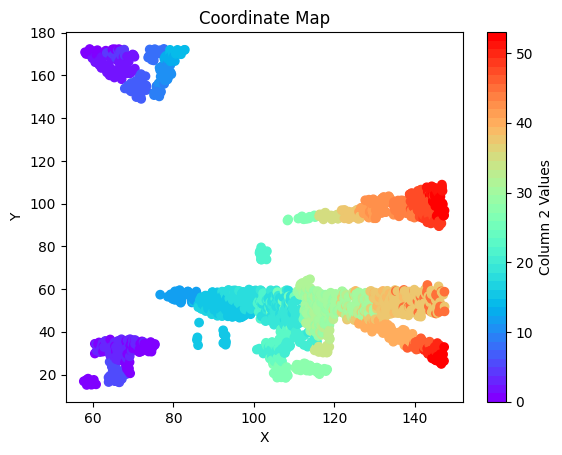

In [35]:
#丢掉10以下的可视化kmeans场景图及分类
x = df_temp2.iloc[:, 2].round(2)
y = df_temp2.iloc[:, 3].round(2)
# colors = df_temp2.loc['final_combination']
colors = df_temp2.iloc[:, 13]

# Set up the color map
cmap = plt.cm.get_cmap('rainbow', 43)

# Create a scatter plot
plt.scatter(x, y, c=colors, cmap=cmap)
# plt.scatter(y, x, c=colors, cmap=cmap)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Column 2 Values')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlabel('Y')
# plt.ylabel('X')
plt.title('Coordinate Map')

# Display the plot
plt.show()


In [85]:
torchvision.models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [100]:
a = [1-2j, 1+2j]
np.abs(a)

array([2.23606798, 2.23606798])

Used for step-by-step debugging of the PyCharm program in Jupyter Notebook. There's no need to run it here.

In [156]:
# import numpy as np

# def generate_matrix(Nt_x, Nt_y, Nc):
#     V_x = np.zeros((Nt_x, Nt_x), dtype=np.complex128)
#     V_y = np.zeros((Nt_y, Nt_y), dtype=np.complex128)
#     F = np.zeros((Nc, Nc), dtype=np.complex128)
#     for z in range(Nt_x):
#         for q in range(Nt_x):
# #             V[z,q] = z + q * 1j
#             V_x[z,q] = 1/np.sqrt(Nt_x) * np.exp(-2 * np.pi * 1j * (z * (q - Nt_x/2)) / Nt_x)
#     for z in range(Nt_y):
#         for q in range(Nt_y):
# #             V[z,q] = z + q * 1j
#             V_y[z,q] = 1/np.sqrt(Nt_y) * np.exp(-2 * np.pi * 1j * (z * (q - Nt_y/2)) / Nt_y)
#     for z in range(Nc):
#         for q in range(Nc):
#             F[z,q] = 1/np.sqrt(Nc) * np.exp(-2 * np.pi * 1j * z * q / Nc)
#     return V_x, V_y, F

# # Generate the matrix
# Nt_x = 8
# Nt_y = 8
# Nc = 64
# V_x, V_y, F = generate_matrix(Nt_x, Nt_y, Nc)
# V_64, _, _ = generate_matrix(64, Nt_y, Nc)

# # Print the matrix
# # print("V_x:",V_x)
# # print("V_y:",V_y)
# print("V:", np.kron(V_x.T.conjugate(), V_y.T.conjugate()))
# print("V_64:",V_64)
# print("V^H:",V.T.conjugate())
# # print("F:",F)

V: [[ 1.25000000e-01-0.00000000e+00j -1.25000000e-01-1.53080850e-17j
   1.25000000e-01+3.06161700e-17j ...  1.25000000e-01+1.83697020e-16j
  -1.25000000e-01-1.99005105e-16j  1.25000000e-01+2.14313190e-16j]
 [ 1.25000000e-01-0.00000000e+00j -8.83883476e-02-8.83883476e-02j
  -2.29621275e-17+1.25000000e-01j ... -8.83883476e-02-8.83883476e-02j
  -1.76042977e-16+1.25000000e-01j  8.83883476e-02-8.83883476e-02j]
 [ 1.25000000e-01-0.00000000e+00j  7.65404249e-18-1.25000000e-01j
  -1.25000000e-01-1.53080850e-17j ... -1.45426807e-16+1.25000000e-01j
   1.25000000e-01+1.53080850e-16j  1.60734892e-16-1.25000000e-01j]
 ...
 [ 1.25000000e-01-0.00000000e+00j  8.83883476e-02+8.83883476e-02j
   7.65404249e-18+1.25000000e-01j ... -6.93889390e-18+1.25000000e-01j
  -8.83883476e-02+8.83883476e-02j -1.25000000e-01+0.00000000e+00j]
 [ 1.25000000e-01-0.00000000e+00j  7.65404249e-18+1.25000000e-01j
  -1.25000000e-01+1.53080850e-17j ...  8.83883476e-02-8.83883476e-02j
   8.83883476e-02+8.83883476e-02j -8.8388347

In [149]:
# e = np.mat("1 2+3j;3 4+5j")
# temp = np.ones((64,64))
# print(e)
# print(e.T.conjugate())
# resu = V.T.conjugate() @ temp @ F
# resu

[[1.+0.j 2.+3.j]
 [3.+0.j 4.+5.j]]
[[1.-0.j 3.-0.j]
 [2.-3.j 4.-5.j]]


array([[ 0.00000000e+00+1.38446986e-14j, -6.31742794e-31-1.01596502e-30j,
        -7.70464155e-31-5.38982345e-31j, ...,
        -1.65878630e-29+2.04563003e-29j,  6.42914482e-30+2.80299855e-30j,
        -8.74896951e-31+3.14404287e-29j],
       [ 5.70654635e-14-3.82055498e-14j, -2.51072353e-30-9.46594568e-32j,
        -3.25864939e-30+3.16622883e-31j, ...,
         1.30094401e-28+9.12674127e-30j, -5.47666467e-30-3.33992364e-29j,
         1.41456605e-28-8.34920964e-29j],
       [ 1.05471187e-14-2.65620859e-14j, -3.61202143e-31+8.60481425e-31j,
         2.52537564e-31-1.96637447e-31j, ...,
         4.60361775e-29-2.78155321e-29j, -9.83133070e-30-8.62831060e-30j,
         2.77684191e-29-6.20420998e-29j],
       ...,
       [-6.56141808e-14+5.71209746e-14j,  6.58098688e-30-3.41705713e-30j,
         3.15188065e-30-4.44177223e-30j, ...,
        -1.62672710e-28+7.29523004e-30j,  1.29351955e-29+3.74326151e-29j,
        -1.66673011e-28+1.32933174e-28j],
       [ 1.05471187e-14+2.65620859e-14j,  1.

In [ ]:
# 'bs0_ue01879.png'

### 2. 一同绘制信道强度热力图和场景2D图